[Table of Contents](./table_of_contents.ipynb)

# The Unscented Kalman Filter

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

In the last chapter we discussed the difficulties that nonlinear systems pose. This nonlinearity can appear in two places. It can be in our measurements, such as a radar that is measuring the slant range to an object. Slant range requires you to take a square root to compute the x,y coordinates:

$$x=\sqrt{\text{slant}^2 - \text{altitude}^2}$$

The nonlinearity can also occur in the process model - we may be tracking a ball traveling through the air, where the effects of air drag lead to nonlinear behavior. The standard Kalman filter performs poorly or not at all with these sorts of problems.

In the last chapter I showed you a plot like this. I have altered the equation somewhat to emphasize the effects of nonlinearity.

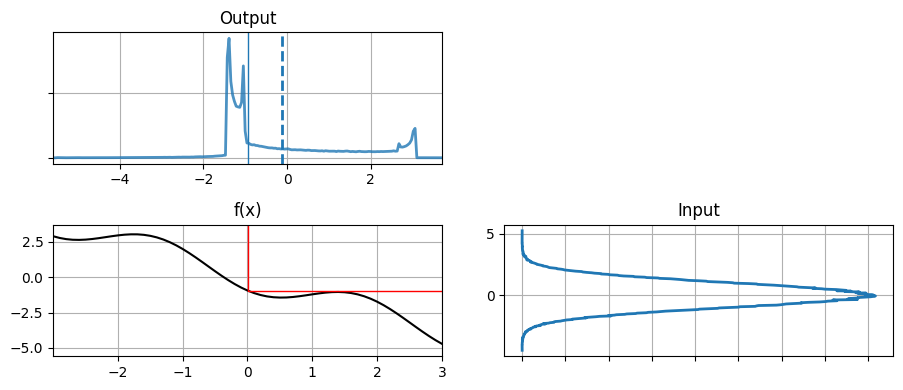

In [3]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

# create 500,000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, f)

I generated this by taking 500,000 samples from the input, passing it through the nonlinear transform, and building a histogram of the result. We call these points *sigma points*. From the output histogram we can compute a mean and standard deviation which would give us an updated, albeit approximated Gaussian.

Let me show you a scatter plot of the data before and after being passed through `f(x)`.

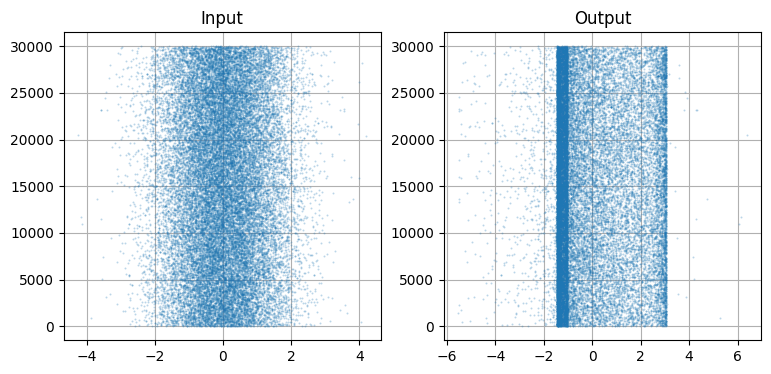

In [4]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1);

The data itself appears to be Gaussian, which it is. By that I mean it looks like white noise scattered around the mean zero. In contrast `g(data)` has a defined structure. There are two  bands, with a significant number of points in between. On the outside of the bands there are scattered points, but with many more on the negative side.

It has perhaps occurred to you that this sampling process constitutes a solution to our problem. Suppose for every update we generated 500,000 points, passed them through the function, and then computed the mean and variance of the result. This is called a *Monte Carlo* approach, and it used by some Kalman filter designs, such as the Ensemble filter and particle filter. Sampling requires no specialized knowledge, and does not require a closed form solution. No matter how nonlinear or poorly behaved the function is, as long as we sample with enough sigma points we will build an accurate output distribution.

"Enough points" is the rub. The graph above was created with 500,000 sigma points, and the output is still not smooth. What's worse, this is only for 1 dimension. The number of points required increases by the power of the number of dimensions. If you only needed 500 points for 1 dimension, you'd need 500 squared, or 250,000 points for two dimensions, 500 cubed, or 125,000,000 points for three dimensions, and so on. So while this approach does work, it is very computationally expensive. Ensemble filters and particle filters use clever techniques to significantly reduce this dimensionality, but the computational burdens are still very large. The unscented Kalman filter uses sigma points but drastically reduces the amount of computation by using a deterministic method to choose the points.

## Sigma Points - Sampling from a Distribution

Let's look at the problem in terms of a 2D covariance ellipse. I choose 2D merely because it is easy to plot; this extends to any number of dimensions. Assuming some arbitrary nonlinear function, we will take random points from the first covariance ellipse, pass them through the nonlinear function, and plot their new position. Then we can compute the mean and covariance of the transformed points, and use that as our estimate of the mean and probability distribution.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


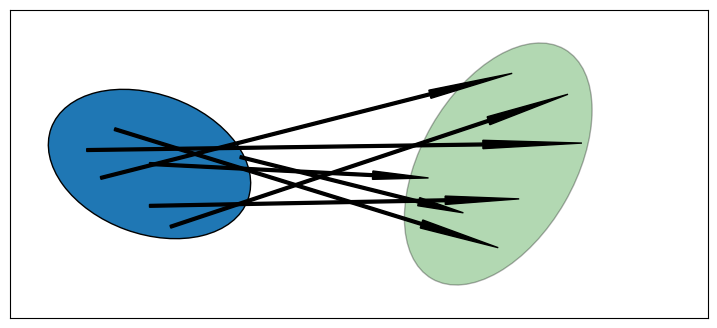

In [5]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

On the left we show an ellipse depicting the $1\sigma$ distribution of two state variables. The arrows show how several randomly sampled points might be transformed by some arbitrary nonlinear function to a new distribution. The ellipse on the right is drawn semi-transparently to indicate that it is an *estimate* of the mean and variance of this collection of points. 

Let's write a function which passes 10,000 points randomly drawn from the Gaussian

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

through the nonlinear system:

$$\begin{cases}\begin{aligned}\bar x&=x+y\\
\bar y&= 0.1x^2 + y^2\end{aligned} \end{cases}$$ 

Difference in mean x=0.058, y=43.307


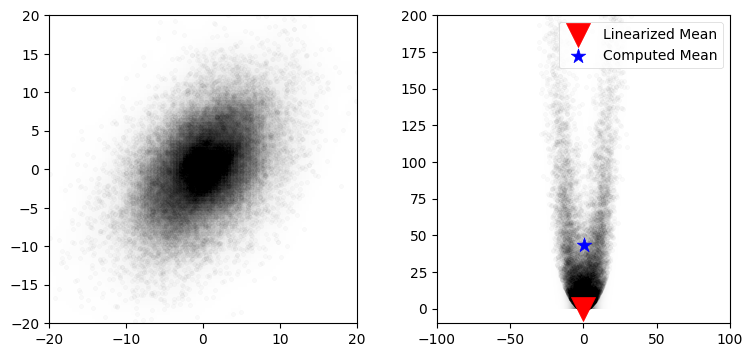

In [6]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

This plot shows the strong nonlinearity that occurs with this function, and the large error that would result if we linearized in the way of the Extended Kalman filter (we will be learning this in the next chapter).

## A Quick Example

I'm soon going to proceed into the math the Unscented Kalman Filter (UKF) uses to choose sigma points and then perform the computation. But let's just start with an example so you can see the destination, so to speak. 

We will learn that the UKF can use many different algorithms to generate the sigma points. Several algorithms are provided by FilterPy. Here's one possibility:

In [7]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

This will become clearer later, but the object will generate weighted sigma points for any given mean and covariance. Let's just look at an example, where the point's size indicate how much it is weighted:

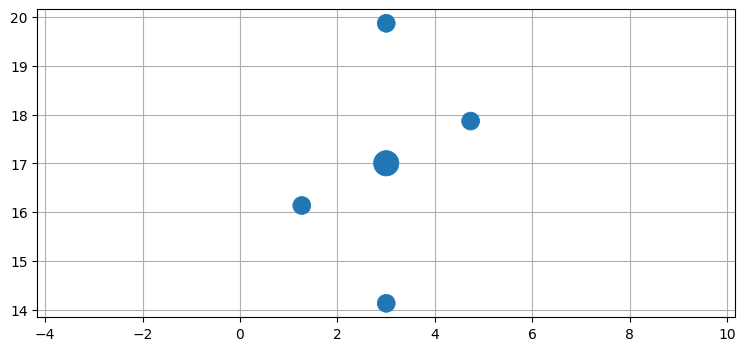

In [8]:
from kf_book.ukf_internal import plot_sigmas
plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])

You can see we have 5 points centered around the mean (3, 17) in an odd pattern. It may seem absurd that this will do as well or better than 500,000 randomly generated points, but it will!

Okay, now let's implement the filter. We will implement a standard linear filter in 1D; we aren't quite ready to tackle a nonlinear filter yet. The design of the filter is not much different than what we have learned so far, with one difference. The KalmanFilter class uses the matrix $\mathbf F$ to compute the state transition function. Matrices mean **linear** algrebra, which work for linear problems, but not nonlinear ones. So, instead of a matrix we provide a function, just like we did above. The KalmanFilter class uses another matrix $\mathbf H$ to implement the measurement function, which converts a state into the equivalent measurement. Again, a matrix implies linearity, so instead of a matrix we provide a function. Perhaps it is clear why $\mathbf H$ is called the 'measurement function'; for the linear Kalman filter it is a matrix, but that is just a fast way to compute a function that happens to be linear. 

Without further ado, here are the state transistion function and measurement function for a 1D tracking problem, where the state is $\mathbf x = [x \, \, \dot x]^ \mathsf T$:


你可以看到，我们有5个点围绕均值(3, 17)呈奇特分布。这看似荒谬——竟能与50万个随机生成的点表现相当甚至更优，但事实确实如此！

现在开始实现滤波器。我们将实现标准的一维线性滤波器，目前尚不具备处理非线性滤波器的条件。滤波器设计与先前所学差异不大，仅有一处区别：KalmanFilter类使用矩阵$\mathbf F$计算状态转移函数。矩阵涉及**线性**代数，适用于线性问题但无法处理非线性问题。因此我们改用函数替代矩阵，正如前文所示。KalmanFilter类使用另一矩阵$\mathbf H$实现测量函数，该函数将状态转换为等效测量值。同样地，矩阵隐含线性特性，故我们提供函数而非矩阵。或许现在能理解为何将 $\mathbf H$ 称为“测量函数”：在线性卡尔曼滤波中它确实是矩阵，但这只是计算线性函数的快速实现方式。

言归正传，以下是一维跟踪问题的状态转移函数与测量函数，其中状态为 $\mathbf x = [x \, \, \dot x]^ \mathsf T$：

In [9]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

Let's be clear, this is a linear example. There is no need to use a UKF for a linear problem, but I'm starting with the simplest possible example. But notice how I wrote `fx()` to compute $\mathbf{\bar x}$ as a set of equations instead of a matrix multiplication. This is to illustrate that I could implement any arbitrary nonlinear function here; we are not constrained to linear equations.

The rest of the design is the same. Design $\mathbf P$, $\mathbf R$, and $\mathbf Q$. You know how to do that, so let's just finish up the filter and run it.

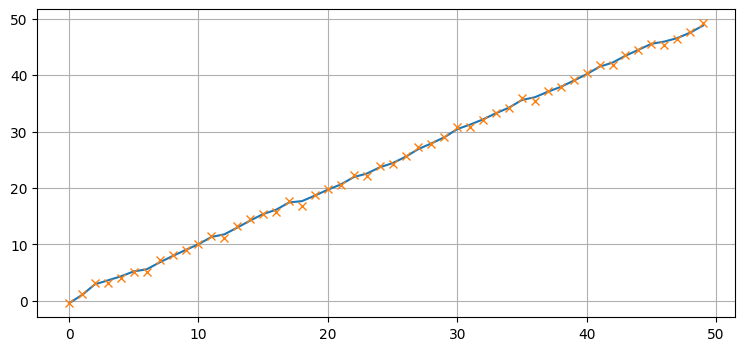

In [10]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs);
plt.plot(zs, marker='x', ls='');

There really isn't a lot new here. You have to create an object that creates sigma points for you, and provide functions instead of matrices for $\mathbf F$ and $\mathbf H$, but the rest is the same as before. This should give you enough confidence to plow through a bit of math and algorithms so you can understand what the UKF is doing.

## Choosing Sigma Points

At the start of the chapter I used 500,000 randomly generated sigma points to compute the the probability distribution of a Gaussian passed through a nonlinear function. While the computed mean is quite accurate, computing 500,000 points for every update would cause our filter to be extremely slow. So, what would be fewest number of sampled points that we can use, and what kinds of constraints does this problem formulation put on the points? We will assume that we have no special knowledge about the nonlinear function as we want to find a generalized algorithm that works for any function.

Let's consider the simplest possible case and see if it offers any insight. The simplest possible system is the **identity function**: $f(x) = x$. If our algorithm does not work for the identity function then the filter cannot converge. In other words, if the input is  1 (for a one dimensional system), the output must also be 1. If the output was different, such as 1.1, then when we fed 1.1 into the transform at the next time step, we'd get out yet another number, maybe 1.23. This filter diverges. 

The fewest number of points that we can use is one per dimension. This is the number that the linear Kalman filter uses. The input to a Kalman filter for the distribution $\mathcal{N}(\mu,\sigma^2)$ is $\mu$ itself. So while this works for the linear case, it is not a good answer for the nonlinear case.

Perhaps we can use one point per dimension, but altered somehow. However, if we were to pass some value $\mu+\Delta$ into the identity function $f(x)=x$ it would not converge, so this will not work. If we didn't alter $\mu$ then this would be the standard Kalman filter. We must conclude that one sample will not work.

What is the next lowest number we can choose? Two. Consider the fact that Gaussians are symmetric, and that we probably want to always have one of our sample points be the mean of the input for the identity function to work. Two points would require us to select the mean, and then one other point. That one other point would introduce an asymmetry in our input that we probably don't want. It would be very difficult to make this work for the identity function $f(x)=x$.

The next lowest number is 3 points. 3 points allows us to select the mean, and then one point on each side of the mean, as depicted on the chart below.

## 选择西格玛点

在本章开头，我使用50万个随机生成的西格玛点来计算经过非线性函数处理的高斯概率分布。虽然计算出的均值相当精确，但每次更新都计算50万个点会导致滤波器运行极其缓慢。那么，我们能使用的最小采样点数是多少？这种问题设定对采样点有何约束？我们将假设对非线性函数无特殊先验知识，以期建立适用于任意函数的通用算法。

让我们从最简单的案例入手，看看能否获得启示。最简单的系统是**恒等函数**：$f(x) = x$。若算法对恒等函数失效，则滤波器无法收敛。换言之，当输入为1（一维系统）时，输出必须为1。若输出出现偏差（如1.1），则下时间步输入1.1时将得到1.23等新数值，导致滤波器发散。

我们能使用的最少点数是每维一个点。这是线性卡尔曼滤波器采用的数量。对于分布 $\mathcal{N}(\mu,\sigma^2)$ 的卡尔曼滤波器，其输入本身就是 $\mu$。因此虽然这适用于线性情况，但对非线性情况并非理想解。

或许可采用每维一个样本点但加以变换的方式。然而若将值 $\mu+\Delta$ 输入恒等函数 $f(x)=x$，该滤波器将无法收敛，故不可行。若不改变 $\mu$ 则等同于标准卡尔曼滤波器。由此可知单样本方案不可行。

那么最小取值是多少？两个。需考虑高斯分布的对称性，且为使恒等函数有效，我们通常希望其中一个采样点始终为输入均值。选择两点需取均值点，再取一个其他点。该额外点将引入输入的不对称性，这通常是不希望的。要使恒等函数 $f(x)=x$ 成立将非常困难。

次优选择是三点。三点方案可选取均值点，并在均值点两侧各取一点，如下图所示。


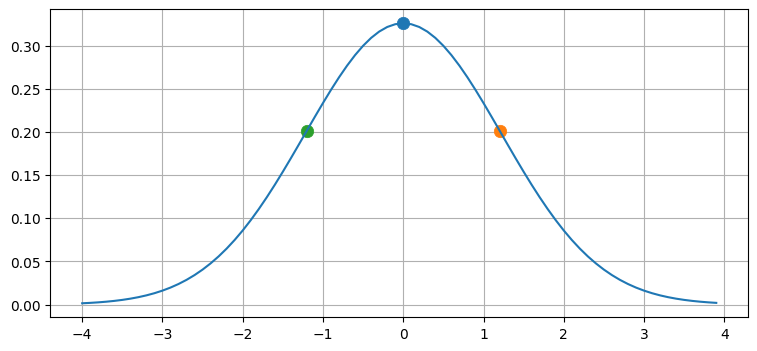

In [11]:
ukf_internal.show_3_sigma_points()

We can pass these points through a nonlinear function f(x) and compute the resulting mean and variance. The mean can be computed as the average of the 3 points, but that is not very general. For example, for a very nonlinear problem we might want to weight the center point much higher than the outside points, or we might want to weight the outside points higher. 

A more general approach is to compute the weighted mean $\mu = \sum_i w_i\, f(\mathcal{X}_i)$, where the calligraphic $\mathcal{X}$ are the sigma points.  We need the sums of the weights to equal one. Given that requirement, our task is to select $\mathcal{X}$ and their corresponding weights so that they compute to the mean and variance of the transformed sigma points. 

If we weight the means it also makes sense to weight the covariances. It is possible to use different weights for the mean ($w^m$) and for the covariance ($w^c$). I use superscripts to allow space for indexes in the following equations. We can write

$$\begin{aligned}
\mathbf{Constraints:}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

The first two equations are the constraint that the weights must sum to one. The third equation is how you compute a weight mean. The forth equation may be less familiar, but recall that the equation for the covariance of two random variables is:

$$COV(x,y) = \frac{\sum(x-\bar x)(y-\bar{y})}{n}$$

These constraints do not form a unique solution. For example, if you make $w^m_0$ smaller you can compensate by making $w^m_1$ and $w^m_2$ larger. You can use different weights for the mean and covariances, or the same weights. Indeed, these equations do not require that any of the points be the mean of the input at all, though it seems 'nice' to do so, so to speak.

We want an algorithm that satisfies the constraints, preferably with only 3 points per dimension. Before we go on I want to make sure the idea is clear. Below are three different examples for the same covariance ellipse with different sigma points. The size of the sigma points is proportional to the weight given to each.

我们可以将这些点代入非线性函数 f(x) 并计算所得的均值与方差。均值可直接取三点平均值，但这种方法不够通用。例如对于高度非线性问题，我们可能需要赋予中心点远高于外围点的权重，或者反之赋予外围点更高权重。

更通用的方法是计算加权均值 $\mu = \sum_i w_i\, f(\mathcal{X}_i)$，其中希腊字母 $\mathcal{X}$ 表示 sigma 点。此时需确保权重之和等于1。基于此要求，我们的任务是选择 $\mathcal{X}$ 及其对应权重，使其计算结果等于转换后 sigma 点的均值与方差。

若对均值进行加权，则协方差加权亦合理。均值（$w^m$）与协方差（$w^c$）可采用不同权重。下式中使用上标以留出索引空间：

$$\begin{aligned}
\mathbf{约束条件：}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

前两条方程是权重之和必为1的约束条件。第三条方程是计算权重均值的方式。第四条方程可能较为陌生，但需回顾两个随机变量的协方差公式：

$$COV(x,y) = \frac{\sum(x-\bar x)(y-\bar{y})}{n}$$

这些约束条件不存在唯一解。例如，当$w^m_0$减小时，可通过增大$w^m_1$和$w^m_2$来补偿。均值与协方差可采用不同权重，亦可使用相同权重。实际上，这些方程并不要求任何点必须是输入均值——尽管这样做看似“合理”。

我们需要一个满足约束条件的算法，且每维度最好仅使用3个点。继续探讨前，需确保概念清晰。下图展示了同一协方差椭圆在不同σ点位置下的三种情形。σ点的大小与各自对应的权重成正比。


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


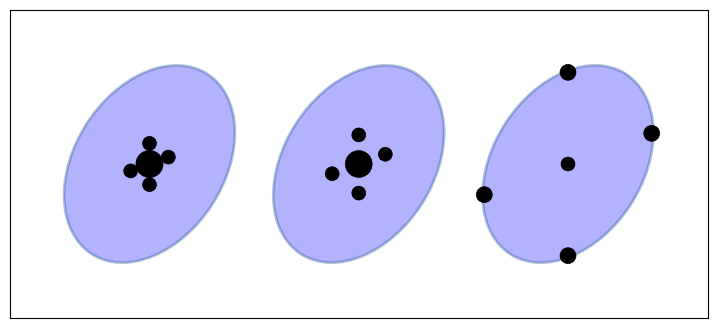

In [12]:
ukf_internal.show_sigma_selections()

The points do not lie along the major and minor axis of the ellipse; nothing in the constraints require me to do that. I show the points evenly spaced, but the constraints do not require that. 

The arrangement and weighting of the sigma points affect how we sample the distribution. Points that are close together will sample local effects, and thus probably work better for very nonlinear problems. Points that are far apart, or far off the axis of the ellipse will sample non-local effects and non Gaussian behavior. However, by varying the weights used for each point we can mitigate this. If the points are far from the mean but weighted very slightly we will incorporate some of the knowledge about the distribution without allowing the nonlinearity of the problem to create a bad estimate. 

Please understand there are infinite ways to select sigma points. The constraints I choose are just one way to do it. For example, not all algorithms for creating the sigma points require the weights to sum to one. In fact, the algorithm I favor in this book does not have that property.

## The Unscented Transform

For the moment, assume an algorithm for selecting the sigma points and weights exists. How are the sigma points used to implement a filter?

The *unscented transform* is the core of the algorithm yet it is remarkably simple. It passes the sigma points $\boldsymbol{\chi}$ through a nonlinear function yielding a transformed set of points. 

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

It then computes the mean and covariance of the transformed points. That mean and covariance becomes the new estimate. The figure below depicts the operation of the unscented transform. The green ellipse on the right represents the computed mean and covariance to the transformed sigma points. 

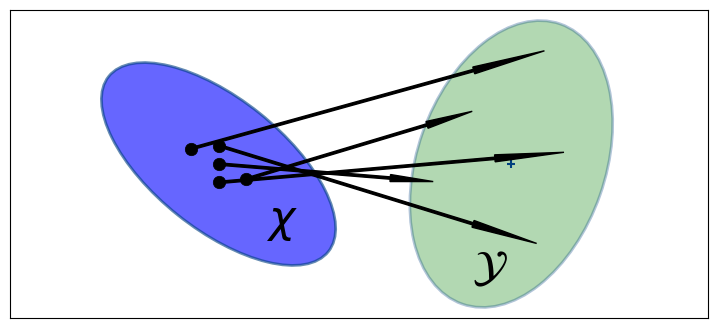

In [13]:
ukf_internal.show_sigma_transform(with_text=True)

The mean and covariance of the sigma points are computed as:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

These equations should be familiar - they are the constraint equations we developed above. 

In short, the unscented transform takes points sampled from some arbitary probability distribution, passes them through an arbitrary, nonlinear function and produces a Gaussian for each transformed points. I hope you can envision how we can use this to implement a nonlinear Kalman filter. Once we have Gaussians all of the mathematical apparatus we have already developed comes into play!

The name "unscented" might be confusing. It doesn't really mean much. It was a joke fostered by the inventor that his algorithm didn't "stink", and soon the name stuck. There is no mathematical meaning to the term.

### Accuracy of the Unscented Transform

Earlier we wrote a function that found the mean of a distribution by passing 50,000 points through a nonlinear function. Let's now pass 5 sigma points through the same function, and compute their mean with the unscented transform. We will use the FilterPy function *MerweScaledSigmaPoints()* to create the sigma points and `unscented_transform` to perform the transform; we will learn about these functions later. In the first example in this chapter I used `JulierSigmaPoints`; they both choose sigma points, but in different ways which I will explain later.

Difference in mean x=-0.097, y=0.549


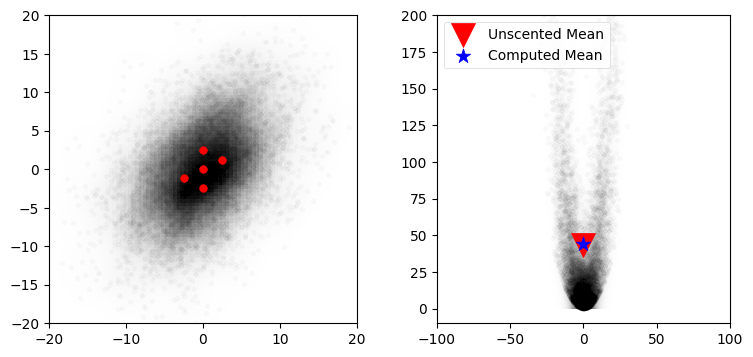

In [14]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

I find this result remarkable. Using only 5 points we were able to compute the mean with amazing accuracy. The error in x is only -0.097, and the error in y is 0.549. In contrast, a linearized approach (used by the EKF, which we will learn in the next chapter) gave an error of over 43 in y. If you look at the code that generates the sigma points you'll see that it has no knowledge of the nonlinear function, only of the mean and covariance of our initial distribution. The same 5 sigma points would be generated if we had a completely different nonlinear function. 

I will admit to choosing a nonlinear function that makes the performance of the unscented tranform striking compared to the EKF. But the physical world is filled with very nonlinear behavior, and the UKF takes it in stride. I did not 'work' to find a function where the unscented transform happened to work well. You will see in the next chapter how more traditional techniques struggle with strong nonlinearities. This graph is the foundation of why I advise you to use the UKF or similar modern technique whenever possible.

## The Unscented Kalman Filter

We can now present the UKF algorithm. 

### Predict Step

The UKF's predict step computes the prior using the process model $f()$. $f()$ is assumed to be nonlinear, so we generate sigma points $\mathcal{X}$ and their corresponding weights $W^m, W^c$
according to some function:

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

We pass each sigma point through $f(\mathbf x, \Delta t)$. This projects the sigma points forward in time according to the process model, forming the new prior, which is a set of sigma points we name $\boldsymbol{\mathcal Y}$:

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

We compute the mean and covariance of the prior using the *unscented transform* on the transformed sigma points.  

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

These are the equations for the unscented transform:

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

This table compares the linear Kalman filter with the Unscented Kalman Filter equations. I've dropped the subscript $i$ for readability.

$$\begin{array}{l|l}
\text{Kalman} & \text{Unscented} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$


### 预测步骤

UKF的预测步骤通过过程模型$f()$计算先验分布。假设$f()$为非线性函数，因此我们根据特定函数生成 sigma 点 $\mathcal{X}$ 及其对应权重 $W^m, W^c$：

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

我们将每个 sigma 点输入 $f(\mathbf x, \Delta t)$。该函数根据过程模型将 sigma 点向前推演，形成新的先验分布——即 sigma 点集合 $\boldsymbol{\mathcal Y}$：

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

我们对转换后的 sigma 点应用*无迹变换*计算先验的均值与协方差。  

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

无迹变换的方程如下：

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

本表对比了线性卡尔曼滤波器与无迹卡尔曼滤波器的方程。为提高可读性，已省略下标$i$。

$$\begin{array}{l|l}
\text{卡尔曼} & \text{无迹} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

### Update Step

Kalman filters perform the update in measurement space. Thus we must convert the sigma points of the prior into measurements using a measurement function $h(x)$ that you define.

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

We compute the mean and covariance of these points using the unscented transform. The $z$ subscript denotes that these are the mean and covariance of the measurement sigma points.

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

Next we compute the residual and Kalman gain. The residual of the measurement $\mathbf z$ is trivial to compute:

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

To compute the Kalman gain we first compute the [cross covariance](https://en.wikipedia.org/wiki/Cross-covariance) of the state and the measurements, which is defined as: 

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

And then the Kalman gain is defined as

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

If you think of the inverse as a *kind of* matrix reciprocal, you can see that the Kalman gain is a simple ratio which computes:

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same Bayesian algorithm we have been implementing throughout the book. 

This table compares the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

### 更新步骤

卡尔曼滤波器在测量空间中执行更新操作。因此，我们必须通过自定义的测量函数 $h(x)$ 将先验分布的 sigma 点转换为测量值。

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

我们通过无迹变换计算这些点的均值与协方差。下标$z$表示这些是测量 sigma 点的均值与协方差。

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

接下来计算残差与卡尔曼增益。测量残差$\mathbf z$的计算很简单：

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

计算卡尔曼增益时，首先计算状态与测量值的[交叉协方差](https://en.wikipedia.org/wiki/Cross-covariance)，其定义为： 

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

随后卡尔曼增益定义为：

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

若将逆矩阵视为*某种形式*的矩阵倒数，可发现卡尔曼增益本质上是计算以下比值的简化形式：

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{状态置信度}}{\text{测量置信度}}$$

最终，我们通过残差与卡尔曼增益计算新状态估计：

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

新协方差计算为：

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

此步骤包含若干需直接接受的公式，但可观察其与线性卡尔曼滤波方程的关联性。虽然线性代数运算略有差异，但算法本质仍是贯穿全书的贝叶斯算法。

下表对比了线性KF与UKF的方程体系：

$$\begin{array}{l|l}
\textrm{卡尔曼滤波} & \textrm{无迹卡尔曼滤波} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$


## Van der Merwe's Scaled Sigma Point Algorithm

There are many algorithms for selecting sigma points.  Since 2005 or so research and industry have mostly settled on the version published by Rudolph Van der Merwe in his 2004 PhD dissertation [1]. It performs well with a variety of problems and it has a good tradeoff between performance and accuracy. It is a slight reformulation of the *Scaled Unscented Transform* published by Simon J. Julier [2].

This formulation uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$. Before we work through the equations, let's look at an example. I will plot the sigma points on top of a covariance ellipse showing the first and second standard deviations, and scale the points based on  the mean weights.

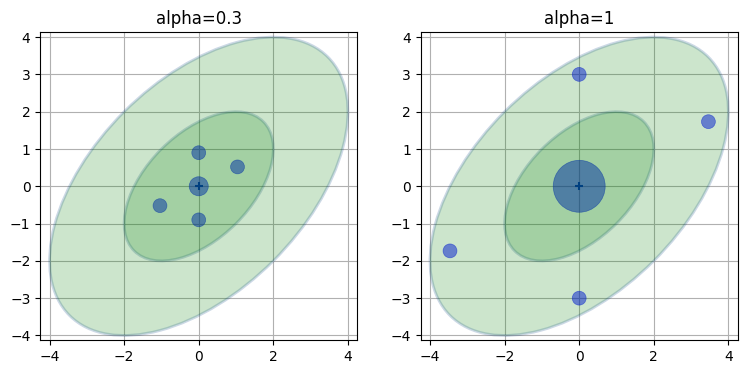

In [15]:
ukf_internal.plot_sigma_points()

We can see that the sigma points lie between the first and second standard deviation, and that the larger $\alpha$ spreads the points out. Furthermore, the larger $\alpha$ weights the mean (center point) higher than the smaller $\alpha$, and weights the rest less. This should fit our intuition - the further a point is from the mean the less we should weight it. We don't know how these weights and sigma points are selected yet, but the choices look reasonable.

我们可以观察到， sigma点分布在第一和第二标准差之间，且随着$\alpha$增大，这些点会向外扩散。此外，较大的$\alpha$赋予均值（中心点）更高的权重，降低其余点的权重。这符合我们的直觉——点距均值越远，其权重就应越小。目前尚不清楚这些权重和 sigma 点是如何选定的，但这些选择看起来是合理的。


### Sigma Point Computation

The first sigma point is the mean of the input. This is the sigma point displayed in the center of the ellipses in the diagram above. We will call this $\boldsymbol{\chi}_0$.

$$ \mathcal{X}_0 = \mu$$

For notational convenience we define $\lambda = \alpha^2(n+\kappa)-n$, where $n$ is the dimension of $\mathbf x$. The remaining sigma points are computed as

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
The $i$ subscript chooses the i$^{th}$ row vector of the matrix.

In other words, we scale the covariance matrix by a constant, take the square root of it, and ensure symmetry by both adding and subtracting it from the mean. We will discuss how you take the square root of a matrix later.

### Weight Computation

This formulation uses one set of weights for the means, and another set for the covariance. The weights for the mean of $\mathcal{X}_0$ is computed as

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

The weight for the covariance of $\mathcal{X}_0$ is

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to $\pm 1\sigma$ times some scaling factor. There is an $n$ term in the denominator, so with more dimensions the points will be spread out and weighed less.

**Important note:** Ordinarily these weights do not sum to one. I get many questions about this. Getting weights that sum to greater than one, or even negative values is expected. I cover this in more detail below.


### Reasonable Choices for the Parameters

$\beta=2$ is a good choice for Gaussian problems, $\kappa=3-n$ where $n$ is the dimension of $\mathbf x$ is a good choice for $\kappa$, and $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value for $\alpha$ spreads the sigma points further from the mean.

### 西格玛点计算

首个西格玛点即输入的均值。该点在图示椭圆中心处显示，记为$\boldsymbol{\chi}_0$。

$$ \mathcal{X}_0 = \mu$$

为便于记号，定义 $\lambda = \alpha^2(n+\kappa)-n$，其中 $n$ 为 $\mathbf x$ 的维数。其余 sigma 点按下列公式计算：

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
下标$i$用于选择矩阵的第$i$行向量。

换言之，我们通过常数缩放协方差矩阵，取其平方根，并通过在均值两端同时加减该常数来确保对称性。矩阵开方运算将在后续章节讨论。

### 权重计算

该公式采用两组权重分别处理均值与协方差。$\mathcal{X}_0$均值的权重计算为：

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

$\mathcal{X}_0$协方差的权重为：

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

其余 sigma 点 $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ 的均值与协方差权重相同：

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

此设计看似“正确”的依据可能不甚明显，且确实无法证明其适用于所有非线性问题。但可观察到：我们选择的 sigma 点与协方差矩阵的平方根成正比，而方差的平方根即为标准差。因此 sigma 点大致按 $\pm 1\sigma$ 乘以某个缩放因子进行分布。分母中存在$n$项，因此维度增加时点分布会更分散且权重降低。

**重要说明：** 通常这些权重之和并不等于1。我收到许多关于此问题的咨询。权重之和大于1甚至出现负值是正常现象，下文将对此进行详细说明。


### 参数的合理取值

对于高斯分布问题，$\beta=2$ 是较优选择；$\kappa=3-n$（其中 $n$ 为 $\mathbf x$ 的维数）是 $\kappa$ 的合理取值；而 $0 \le \alpha \le 1$ 是 $\alpha$ 的适宜范围，其中较大的 $\alpha$ 值会使 sigma 点更远离均值。


## Using the UKF

Let's solve some problems so you can gain confidence in how easy the UKF is to use. We will start with a linear problem you already know how to solve with the linear Kalman filter. Although the UKF was designed for nonlinear problems, it finds the same optimal result as the linear Kalman filter for linear problems. We will write a filter to track an object in 2D using a constant velocity model. This will allow us to focus on what is the same (and most is the same!) and what is different with the UKF. 

Designing a Kalman filter requires you to specify the $\bf{x}$, $\bf{F}$, $\bf{H}$, $\bf{R}$, and $\bf{Q}$ matrices. We have done this many times so I will give you the matrices without a lot of discussion. We want a constant velocity model, so we define $\bf{x}$ to be

$$ \mathbf x = \begin{bmatrix}x &  \dot x & y & \dot y \end{bmatrix}^\mathsf{T}$$

With this ordering of state variables the state transition matrix is

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

which implement the Newtonian equations

$$\begin{aligned}
x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}$$

Our sensors provide position but not velocity, so the measurement function is

$$\mathbf H = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

The sensor readings are in meters with an error of $\sigma=0.3$ meters in both *x* and *y*. This gives us a measurement noise matrix of 

$$\mathbf R = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

Finally, let's assume that the process noise can be represented by the discrete white noise model - that is, that over each time period the acceleration is constant. We can use `FilterPy`'s `Q_discrete_white_noise()` to create this matrix for us, but for review the matrix is

$$\mathbf Q = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

My implementation of this filter is:


## 使用无迹卡尔曼滤波器

让我们通过解决几个问题，让你对无迹卡尔曼滤波器的易用性建立信心。我们将从一个线性问题开始，你已经知道如何使用线性卡尔曼滤波器来解决它。尽管无迹卡尔曼滤波器是为非线性问题设计的，但在线性问题中它能得出与线性卡尔曼滤波器相同的最优结果。我们将编写一个滤波器，使用恒定速度模型来追踪二维空间中的物体。这将使我们能够聚焦于两者相同之处（绝大多数是相同的！）与不同之处。

设计卡尔曼滤波器需要指定矩阵 $\bf{x}$、$\bf{F}$、$\bf{H}$、$\bf{R}$ 和 $\bf{Q}$。我们已多次进行过此类操作，因此在此直接给出矩阵而不再赘述。为实现恒定速度模型，我们定义状态向量为：

$$ \mathbf x = \begin{bmatrix}x &  \dot x & y & \dot y \end{bmatrix}^\mathsf{T}$$

按此状态变量排序，状态转移矩阵为：

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

该矩阵实现牛顿方程：

$$\begin{aligned}
x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}$$

传感器仅提供位置信息而非速度，故测量函数为：

$$\mathbf H = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

传感器读数单位为米，且在*x*和*y*方向均存在$\sigma=0.3$米的误差。由此得到测量噪声矩阵：

$$\mathbf R = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

最后，假设过程噪声可由离散白噪声模型表示——即每个时间段内加速度保持恒定。可使用`FilterPy`的`Q_discrete_white_noise()`函数生成该矩阵，但为便于回顾，矩阵形式如下：

$$\mathbf Q = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

我实现的滤波器代码如下：

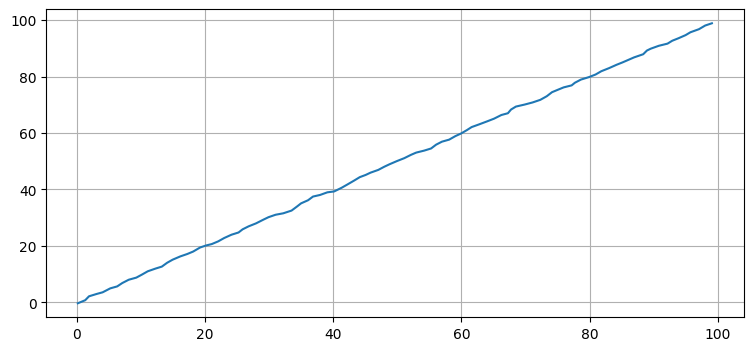

In [16]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = .3, .3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x**2, std_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2]);

This should hold no surprises for you. Now let's implement a UKF. Again, this is purely for educational purposes; using a UKF for a linear problem confers no benefit. `FilterPy` implements the UKF with the class `UnscentedKalmanFilter`. 

The first thing to do is implement the functions `f(x, dt)` and `h(x)`. `f(x, dt)` implements the state transition function, and `h(x)` implements the measurement function. These correspond to the matrices $\mathbf F$ and $\mathbf H$ in the linear filter.

Below is a reasonable implementation of these two functions. Each is expected to return a 1D NumPy array or list containing the result. You may give them more readable names than `f` and `h`.

In [17]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

Next you specify how to compute the sigma points and weights. We gave Van der Merwe's  version above, but there are many different choices. FilterPy uses a class named `SigmaPoints` which must implement a method:

```python
def sigma_points(self, x, P)
```

and contain attributes `Wm` and `Wc`, which hold the weights for computing the mean and covariance, respectively.

FilterPy derives the class `MerweScaledSigmaPoints` from `SigmaPoints` and implements the aforementioned methods.

When you create the UKF you will pass in the $f()$ and $h()$ functions and the sigma point  object, as in this example:

```python
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=points)
```

The rest of the code is the same as for the linear kalman filter. I'll use the same measurements and compute the standard deviation of the difference between the two solutions.

UKF standard deviation 0.013 meters


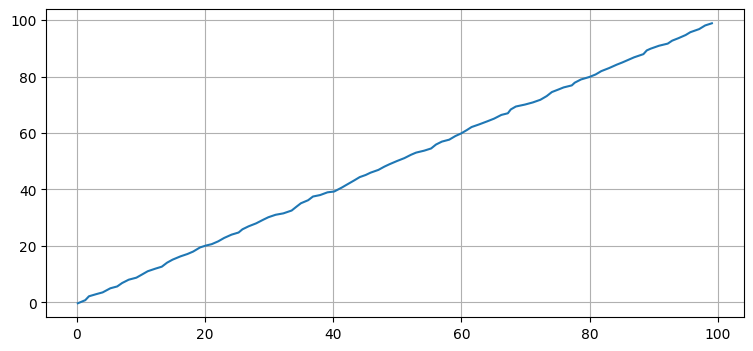

In [18]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs, _ = ukf.batch_filter(zs)
# uxs = []
# for z in zs:
#     ukf.predict()
#     ukf.update(z)
#     uxs.append(ukf.x.copy())
# uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

This gave me a standard deviation of 0.013 meters, which is quite small. 

The implementation of the UKF is not that different from the linear Kalman filter. Instead of implementing the state transition and measurement functions as the matrices $\mathbf F$ and $\mathbf H$ you supply nonlinear functions `f()` and `h()`. The rest of the theory and implementation remains the same. The code implementing `predict()` and `update()` differs, but from a designer's point of view the problem formulation and filter design is very similar.

## Tracking an Airplane

Let's tackle our first nonlinear problem. We will write a filter to track an airplane using radar as the sensor. To keep the problem as similar to the previous one as possible we will track in two dimensions. We will track one dimension on the ground and the altitude of the aircraft. Each dimension is independent so we can do this with no loss of generality.

Radars work by emitting radio waves or microwaves. Anything in the beam's path will reflect some of the signal back to the radar. By timing how long it takes for the reflected signal to return it can compute the *slant distance* to the target. Slant distance is the straight line distance from the radar to the object. Bearing is computed using the *directive gain* of the antenna.

We compute the (x,y) position of the aircraft from the slant distance and elevation angle as illustrated by this diagram:

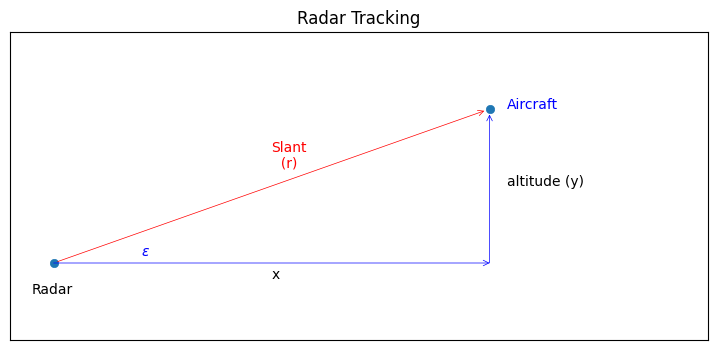

In [19]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

The *elevation angle* $\epsilon$ is the angle above the line of sight formed by the ground.

We will assume that the aircraft is flying at a constant altitude. Thus we have a three variable state vector:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

The state transition function is linear 

$$\mathbf{\bar x} = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}
$$

and can be computed with:

In [20]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

Next we design the measurement function. As in the linear Kalman filter the measurement function converts the filter's prior into a measurement. We need to convert the position and velocity of the aircraft into the elevation angle and range from the radar station.

Range is computed with the Pythagorean theorem:

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\mathtt{radar})^2}$$

The elevation angle $\epsilon$ is the arctangent of $y/x$:

$$\epsilon = \tan^{-1}{\frac{y_\mathtt{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$

We need to define a Python function to compute this. I'll take advantage of the fact that a function can own a variable to store the radar's position. While this isn't necessary for this problem (we could hard code the value, or use a global), this gives the function more flexibility.

In [21]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

There is a nonlinearity that we are not considering, the fact that angles are modular. The residual is the difference between the measurement and the prior projected into measurement space. The angular difference between 359° and 1° is 2°, but 359° - 1° = 358°. This is exacerbated by the UKF which computes sums of weighted values in the unscented transform. For now we will place our sensors and targets in positions that avoid these nonlinear regions. Later I will show you how to handle this problem.

We need to simulate the radar and the aircraft. By now this should be second nature for you, so I offer the code without discussion.


存在一种我们尚未考虑的非线性特性，即角度具有模性。残差是测量值与先验值在测量空间中投影后的差值。359°与1°之间的角度差为2°，但359° - 1° = 358°。这种非线性在UKF中尤为突出，其在无迹变换中计算加权值之和。当前我们将传感器与目标置于避开这些非线性区域的位置。后续我会展示如何处理此问题。

我们需要模拟雷达与飞机。此时这应已成为你的第二本能，故直接提供代码而不作赘述。

In [22]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

A military grade radar achieves 1 meter RMS range accuracy, and 1 mrad RMS for elevation angle [3]. We will assume a more modest 5 meter range accuracy, and 0.5° angular accuracy as this provides a more challenging data set for the filter.

The design of $\mathbf Q$ requires some discussion. The state is $\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$. The first two elements are down range distance and velocity, so we can use `Q_discrete_white_noise` noise to compute the values for the upper left hand side of Q. The third element is altitude, which we assume is independent of $x$. That results in a block design for $\mathbf Q$:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & \boldsymbol 0 \\ \boldsymbol 0 & Q_\mathtt{y}\end{bmatrix}$$

I'll start with the aircraft positioned directly over the radar station, flying at 100 m/s. A typical height finder radar might update only once every 3 seconds so we will use that for our epoch period. 

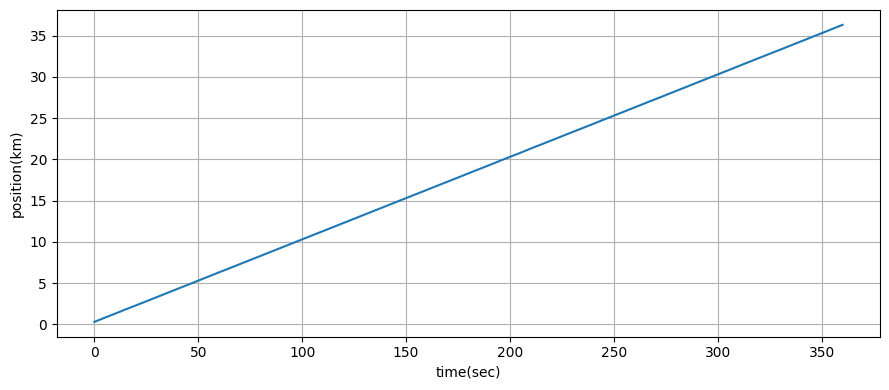

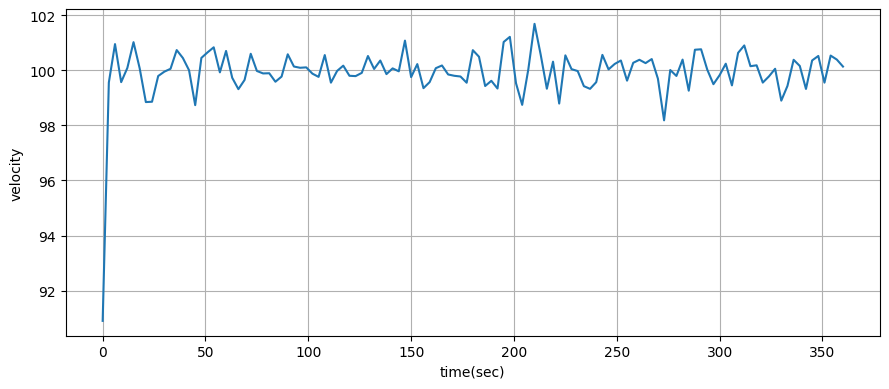

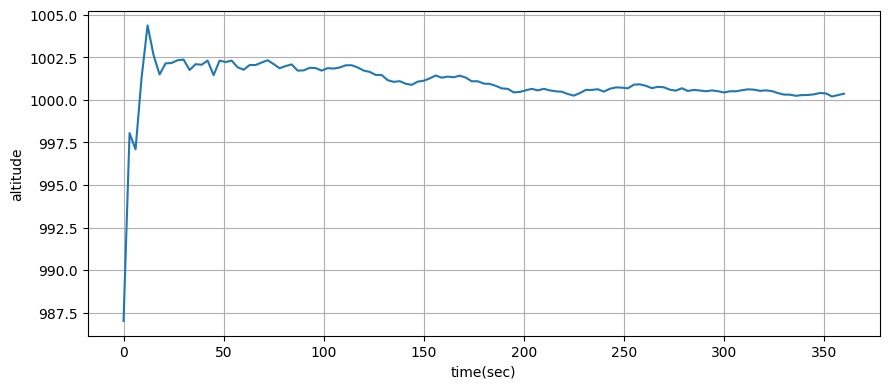

In [23]:
import math
from kf_book.ukf_internal import plot_radar

dt = 3. # 3 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, elevation_angle_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)    
plot_radar(xs, time)

This may or may not impress you, but it impresses me! In the Extended Kalman filter chapter we will solve the same problem, but it will take a significant amount of mathematics. 

### Tracking Maneuvering Aircraft

The previous example produced good results, but it assumed the aircraft did not change altitude. Here are the filter results if the aircraft starts climbing after one minute.

Actual altitude: 2515.6
UKF altitude   : 1042.1


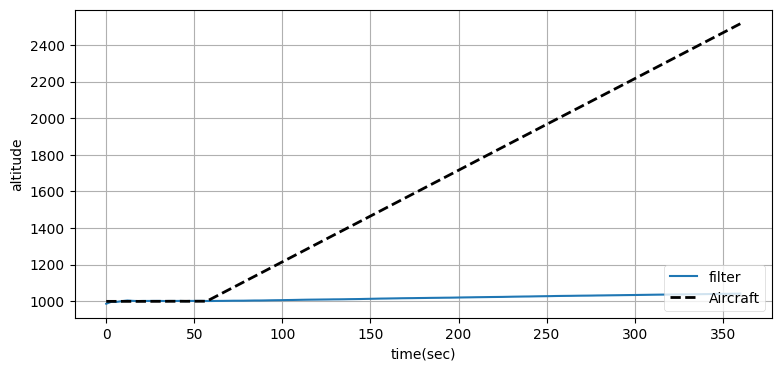

In [24]:
from kf_book.ukf_internal import plot_altitude

# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

The filter is unable to track the changing altitude. What do we have to change in our design?

I hope you answered "add climb rate to the state", like so:


$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

This requires the following change to the state transition function, which is still linear.

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&\Delta t \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot x\\ y\\ \dot y\end{bmatrix} 
$$

The measurement function stays the same, but we must alter $\mathbf Q$ to account for the dimensionality change of $\mathbf x$.

In [25]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return F @ x
    
def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)

    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = kf.R @ kf.R  # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

Actual altitude: 2515.6
UKF altitude   : 2500.1


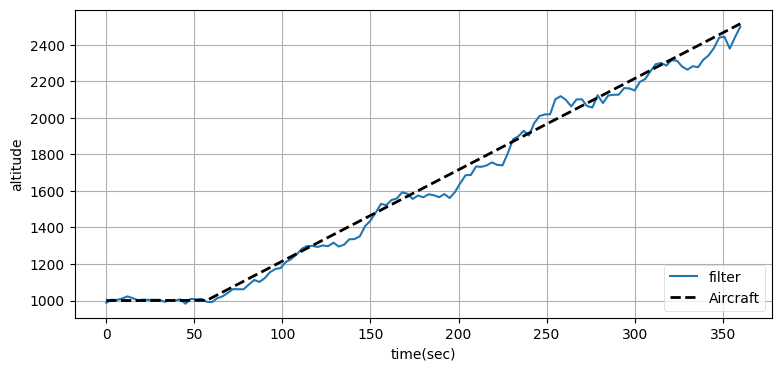

In [26]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

my_kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    my_kf_cv.predict()
    my_kf_cv.update([r[0], r[1]]) 
    xs.append(my_kf_cv.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

Actual altitude: 2515.6
UKF altitude   : 2500.1


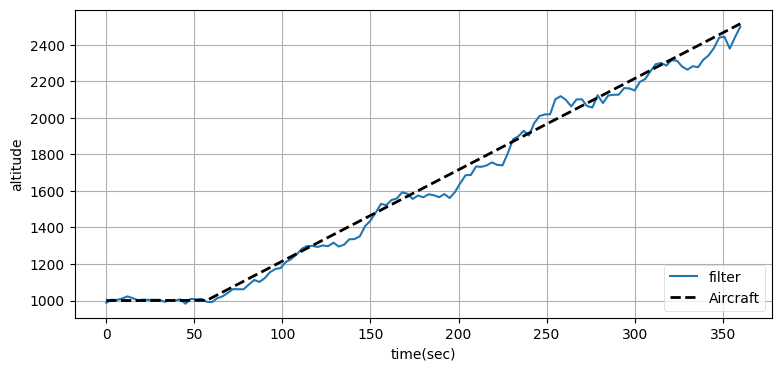

In [28]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)


class RadarH:
    radar_pos: np.ndarray

    def __init__(self, radar_pos: tuple[float, float]):
        self.radar_pos = np.array([radar_pos[0], radar_pos[1]])

    def h(self, x: np.ndarray):
        delta_pos = x[[0, 2]] - self.radar_pos
        slant_range = np.linalg.norm(delta_pos)
        elevation_angle = np.arctan2(delta_pos[1], delta_pos[0])
        return np.array([slant_range, elevation_angle])


class ACF:
    def __init__(self, dt: float) -> None:
        self.F = np.asarray([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])

    def f(self, x: np.ndarray):
        return self.F @ x


def f(x: np.ndarray, dt: float):
    F = np.asarray([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    return F @ x


points = MerweScaledSigmaPoints(4, 0.1, 2, -1)

radar_h = RadarH(radar_pos)
my_kf_cv = UKF(4, 2, dt, radar_h.h, f, points)
my_kf_cv.Q[:2, :2] = Q_discrete_white_noise(2, dt, 0.1)
my_kf_cv.Q[2:, 2:] = Q_discrete_white_noise(2, dt, 0.1)

my_kf_cv.R = np.diag([range_std**2, elevation_angle_std**2])

my_kf_cv.x = np.array([0, 90, 1100, 0])
my_kf_cv.P = np.diag([300**2, 3**2, 150**2, 3**2])


time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 5
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])

    my_kf_cv.predict()
    my_kf_cv.update([r[0], r[1]])
    xs.append(my_kf_cv.x)


plot_altitude(xs, time, ys)
print(f"Actual altitude: {ac.pos[1]:.1f}")
print(f"UKF altitude   : {xs[-1][2]:.1f}")

A significant amount of noise has been introduced into the altitude estimate, but we are now accurately tracking altitude.

### Sensor Fusion

Now let's consider an example of sensor fusion. We have some type of Doppler system that produces a velocity estimate with 2 m/s RMS accuracy. I say "some type" because as with the radar I am not trying to teach you how to create an accurate filter for a Doppler system. A full implementation must account for the signal to noise ratio, atmospheric effects, the geometry of the system, and so on. 

The radar's accuracy in the last examples allowed us to estimate velocities to within one m/s or so, I will degrade that accuracy to illustrate the effect of sensor fusion. Let's change the range error to $\sigma=500$ meters and then compute the standard deviation of the estimated velocity. I'll skip the first several measurements because the filter is converging during that time, causing artificially large deviations.

The standard deviation without using Doppler is:

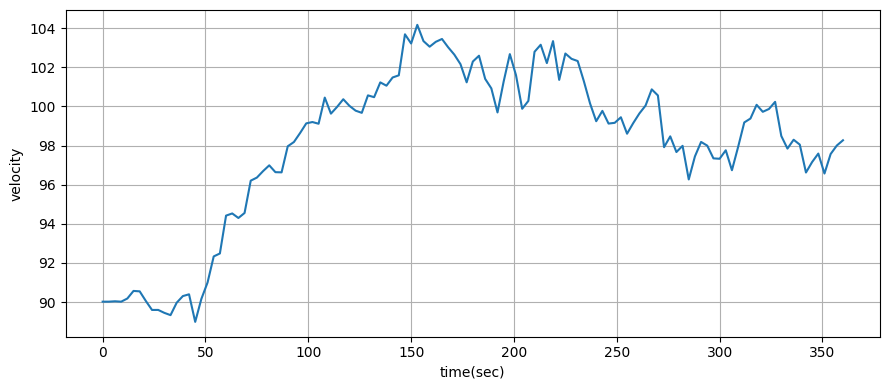

Velocity std 3.4 m/s


In [29]:
range_std = 500.
elevation_angle_std = math.degrees(0.5)
np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_sf = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf_sf.predict()
    kf_sf.update([r[0], r[1]]) 
    xs.append(kf_sf.x)

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:, 1]):.1f} m/s')

For Doppler we need to include the velocity in $x$ and $y$ into the measurement. The `ACSim` class stores velocity in the data member `vel`. To perform the Kalman filter update we just need to call `update` with a list containing the slant distance, elevation angle, and velocity in $x$ and $y$:

$$z = [\mathtt{slant\_range},\, \text{elevation angle},\, \dot x,\, \dot y]$$

The measurement contains four values so the measurement function also needs to return four values. The slant range and elevation angle will be computed as before, and we do not need to compute the velocity in $x$ and $y$ as they are provided by the state estimate.


对于多普勒效应，我们需要将$x$和$y$方向的速度纳入测量值。`ACSim`类将速度存储在数据成员`vel`中。执行卡尔曼滤波器更新时，只需调用`update`函数并传入包含斜距、仰角以及$x$和$y$方向速度的列表：

$$z = [\mathtt{斜距},\, \text{仰角},\, \dot x,\, \dot y]$$

由于测量值包含四个参数，测量函数也需返回四项数据。斜距与仰角按原有方式计算，而$x$和$y$方向的速度无需额外计算，因其由状态估计值直接提供。

In [30]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return slant_range, elevation_angle, x[1], x[3]

Now we can implement our filter.

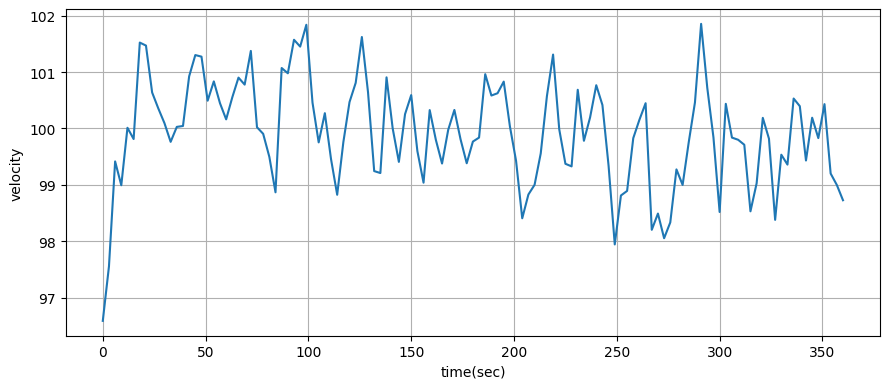

Velocity std 0.9 m/s


In [31]:
h_radar.radar_pos = (0, 0)
h_vel.radar_pos = (0, 0)

range_std = 500.
elevation_angle_std = math.degrees(0.5)
vel_std = 2.

np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)
radar = RadarStation((0, 0), range_std, elevation_angle_std)

kf_sf2 = cv_UKF(f_cv_radar, h_vel, 
            R_std=[range_std, elevation_angle_std, vel_std, vel_std])

time = np.arange(0, 360 + dt, dt)
xs = []
for t in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    # simulate the doppler velocity reading
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf_sf2.predict()
    kf_sf2.update([r[0], r[1], vx, vz]) 
    xs.append(kf_sf2.x)
xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:,1]):.1f} m/s')

By incorporating the velocity sensor we were able to reduce the standard deviation from 3.5 m/s to 1.3 m/s. 

Sensor fusion is a large topic, and this is a rather simplistic implementation. In a typical navigation problem we have sensors that provide *complementary* information. For example, a GPS might provide somewhat accurate position updates once a second with poor velocity estimation while an inertial system might provide very accurate velocity updates at 50Hz but terrible position estimates. The strengths and weaknesses of each sensor are orthogonal to each other. This leads to the *Complementary filter*, which blends the high update rate inertial velocity measurements with the accurate but slowly updated position estimates of the GPS to produce  high rate and accurate position and velocity estimates. The high rate velocity estimates are integrated between the GPS updates to produce accurate and high rate position estimates.

### Multiple Position Sensors

The last sensor fusion problem was a toy example. Let's tackle a problem that is not so toy-like. Before GPS ships and aircraft navigated via various range and bearing systems such as VOR, LORAN, TACAN, DME, and so on. These systems emit beacons in the form of radio waves. The sensor extracts the range and/or bearing to the beacon from the signal. For example, an aircraft might have two VOR receivers. The pilot tunes each receiver to a different VOR station. Each VOR receiver displays the *radial* - the direction from the VOR station on the ground to the aircraft. The pilot uses a chart to find the intersection point of the radials, which identifies the location of the aircraft.

That is a manual approach with low accuracy. A Kalman filter will produce far more accurate position estimates. Assume we have two sensors, each of which provides a bearing only measurement to the target, as in the chart below. The width of the perimeters are proportional to the $3\sigma$ of the sensor noise. The aircraft must be positioned somewhere within the intersection of the two perimeters with a high degree of probability.

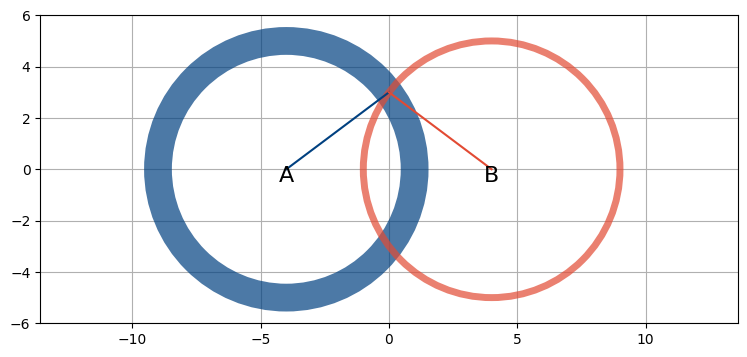

In [32]:
ukf_internal.show_two_sensor_bearing()

We compute the bearing between a sensor and the target as:

In [33]:
def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])

The filter receives the measurement from the two sensors in a vector. The code will accept any iterable container, so I use a Python list for efficiency. We can implement that as:

In [34]:
def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

Assume a constant velocity model for the aircraft. For a change of pace I compute the new positions explicitly rather than using matrix-vector multiplication:

In [35]:
def fx_VOR(x, dt):
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    return x

Next we implement the measurement function. It converts the prior to an array containing the measurement to both stations. I'm not a fan of global variables, but I put the position of the stations in the global variables `sa_pos` and `sb_pos` to demonstrate this method of sharing data with $h()$:

In [36]:
sa_pos = [-400, 0]
sb_pos = [400, 0]

def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)

Now we write boilerplate which constructs the filter, runs it, and plots the results:

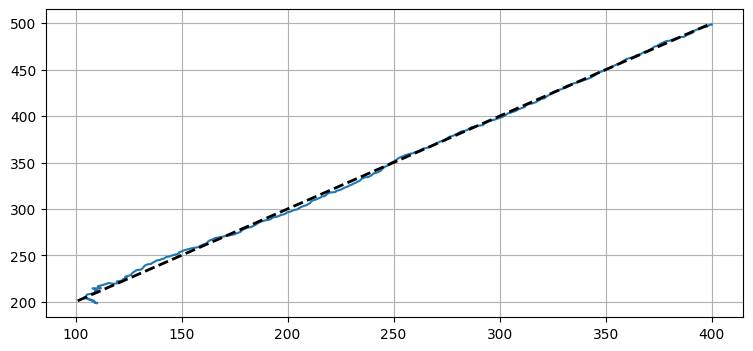

In [37]:
def moving_target_filter(pos, std_noise, Q, dt=0.1, kappa=0.0):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 1000    
    return f

def plot_straight_line_target(f, std_noise):
    xs, txs = [], []
    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()

np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This looks quite good to me. The beginning of the track exhibits large errors, but the filter settles down and produces good estimates.

Let's revisit the nonlinearity of the angles. I will position the target between the two sensors at (0,0). This will cause a nonlinearity in the computation of the residuals because the mean angle will be near zero. As the angle goes below 0 the measurement function will compute a large positive angle of nearly $2\pi$. The residual between the prediction and measurement will thus be very large, nearly $2\pi$ instead of nearly 0. This makes it impossible for the filter to perform accurately, as seen in the example below.


让我们重新审视角度的非线性特性。我将把目标置于两个传感器之间的(0,0)点。这会导致残差计算出现非线性，因为平均角度将接近零。当角度低于0时，测量函数将计算出接近$2\pi$的巨大正角度。预测值与测量值之间的残差因此会变得极大，接近$2\pi$而非接近0。这使得滤波器无法准确运行，如下例所示。

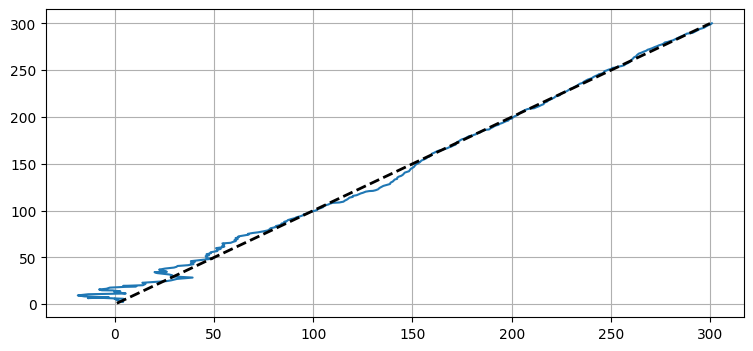

In [38]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This performance is unacceptable. `FilterPy`'s UKF code allows you to specify a function which computes the residuals in cases of nonlinear behavior like this,. The final example in this chapter demonstrates its use.

## Effects of Sensor Error and Geometry

The geometry of the sensors relative to the tracked object imposes a physical limitation that can be extremely difficult to deal with when designing filters. If the radials of the VOR stations are nearly parallel to each other then a very small angular error translates into a very large distance error. What is worse, this behavior is nonlinear - the error in the *x-axis* vs the *y-axis* will vary depending on the actual bearing. These scatter plots  show the error distribution for a 1°$\sigma$ error for two different bearings.


传感器相对于被追踪目标的几何布局存在物理限制，这在设计滤波器时极难处理。若VOR台站的径向线彼此近乎平行，则极小的角度误差会转化为巨大的距离误差。更糟糕的是，这种误差表现呈非线性特征——*x轴*与*y轴*方向的误差值会随实际方位角变化而波动。下图散点图展示了两种不同方位角下1°$\sigma$误差的分布情况。

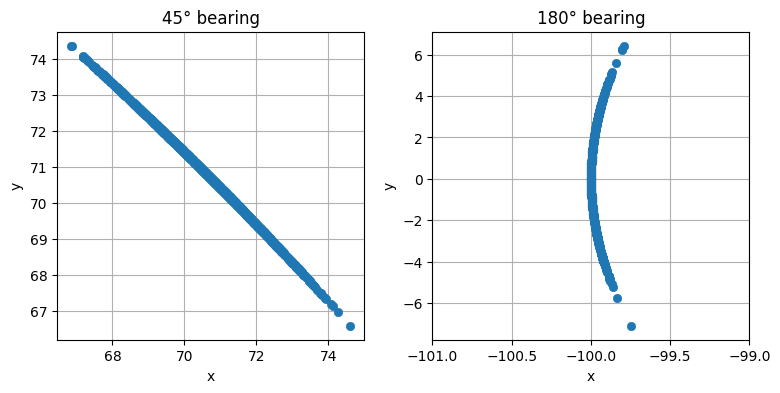

In [39]:
ukf_internal.plot_scatter_of_bearing_error()

## Exercise: Explain Filter Performance

We can see that for small angular errors the positional errors are very large. Explain how we got such relatively good performance out of the UKF in the target tracking problems above. Answer for both the one sensor and multiple sensor problem. 

### Solution

This is very important to understand. Try very hard to answer this before reading the answer below. If you cannot answer this you may need to revisit some of the earlier material in the **Multidimensional Kalman Filter** chapter.

There are several factors contributing to our success. First, let's consider the case of having only one sensor. Any single measurement has an extreme range of possible positions. But, our target is moving, and the UKF is taking that into account. Let's plot the results of several measurements taken in a row for a moving target.

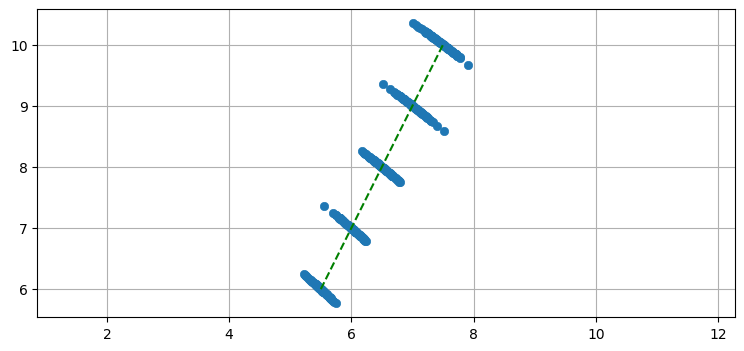

In [40]:
ukf_internal.plot_scatter_moving_target()

Each individual measurement has a very large position error. However, a plot of successive measurements shows a clear trend - the target is obviously moving towards the upper right. When a Kalman filter computes the Kalman gain it takes the distribution of errors into account by using the measurement function. In this example the error lies on an approximately 45° line, so the filter will discount errors in that direction. On the other hand, there is almost no error in measurement orthogonal to that, and again the Kalman gain will take that into account. 

This graph makes it look easy because we have plotted 100 measurements for each position update. The movement of the aircraft is obvious. In contrast, the Kalman filter only gets one measurement per update. Therefore the filter will not be able to generate as good a fit as the dotted green line implies. 

Now consider that the bearing gives us no distance information. Suppose we set the initial estimate to 1,000 kilometers away from the sensor (vs the actual distance of 7.07 km) and make $\mathbf P$ very small. At that distance a 1° error translates into a positional error of 17.5 km. The KF would never be able to converge onto the actual target position because the filter is incorrectly very certain about its position estimates and because there is no distance information provided in the measurements.


每次单独测量都存在相当大的位置误差。然而，连续测量数据的图示呈现出明显趋势——目标显然正向右上方移动。卡尔曼滤波器在计算卡尔曼增益时，会通过测量函数将误差分布纳入考量。本例中误差分布大致呈45°线状，因此滤波器将削弱该方向的误差影响。另一方面，与该方向正交的测量几乎没有误差，卡尔曼增益同样会对此进行调整。

此图之所以显得简单，是因为我们为每次位置更新绘制了100次测量数据。飞机的运动轨迹清晰可见。而实际中卡尔曼滤波器每次更新仅获得一次测量数据，因此其拟合效果无法达到图中绿点线所示的精度。

现在考虑方位角无法提供距离信息的情况。假设我们将初始估计值设为距传感器1000公里（实际距离为7.07公里），并使$\mathbf P$非常小。在该距离下，1°方位误差将导致17.5公里位置偏差。卡尔曼滤波器永远无法收敛至真实目标位置——因其错误地对位置估计过度自信，且测量数据中缺乏距离信息。

Now let's consider the effect of adding a second sensor. Here are two plots showing the effects of different sensor placements. I used a square and a triangle as a symbol for the two sensors, and drew a distribution of the errors due to each sensor using the same symbol shape and color. I then computed the $(x, y)$ coordinate corresponding to the two noisy bearing measurements and plotted them with red dots to show the distribution of the noisy measurements in $x$ and $y$.


现在我们来考虑添加第二个传感器的影响。下图展示了不同传感器位置的效果。我用正方形和三角形分别代表两个传感器，并用相同符号形状和颜色绘制了每个传感器产生的误差分布。随后计算出两个噪声方位测量值对应的$(x, y)$坐标，用红点标注以显示噪声测量值在$x$和$y$轴上的分布情况。

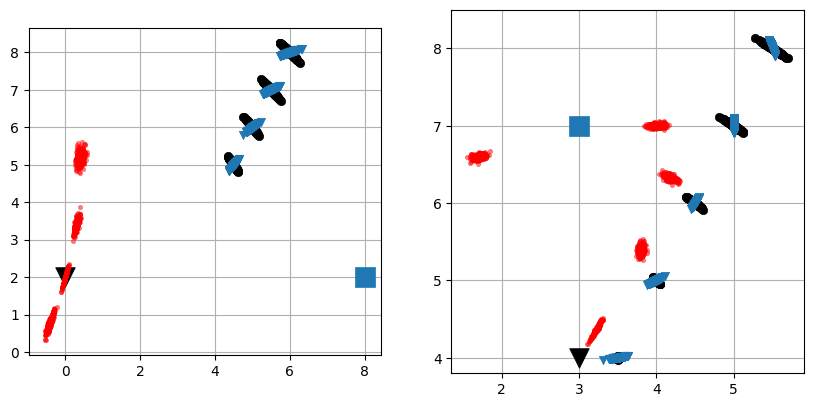

In [41]:
with figsize(10,5):
    ukf_internal.plot_iscts_two_sensors()

In the first plot I placed the sensors nearly orthogonal to the target's initial position so we get these lovely 'x' shape intersections. We can see how the errors in $x$ and $y$ change as the target moves by the shape the scattered red dots make - as the target gets further away from the sensors, but nearer the $y$ coordinate of sensor B the shape becomes strongly elliptical.

In the second plot the airplane starts very near one sensor, and then flies past the second sensor. The intersections of the errors are very non-orthogonal, and the resulting position errors become very spread out.


在第一幅图中，我将传感器几乎垂直于目标初始位置布置，因此形成了这些漂亮的“X”形交叉点。通过散布的红点形状，我们可以观察到目标移动时$x$和$y$方向误差的变化——当目标远离传感器但接近传感器B的$y$坐标时，交叉点形状会明显呈现椭圆形态。

在第二幅图中，飞机起始位置极靠近某传感器，随后飞越第二传感器。误差交点呈现显著非正交特性，导致位置误差分布极度分散。

## Implementation of the UKF

FilterPy implements the UKF, but it is instructive to learn how to translate equations into code. Implementing the UKF is quite straightforward. First, let's write code to compute the mean and covariance of the sigma points. 

We will store the sigma points and weights in matrices, like so:

$$ 
\begin{aligned}
\text{weights} &= 
\begin{bmatrix}
w_0& w_1 & \dots & w_{2n}
\end{bmatrix} 
\\
\text{sigmas} &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} & \dots & \mathcal{X}_{0,n-1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \dots & \mathcal{X}_{1,n-1} \\
\vdots & \vdots &  \ddots & \vdots \\
\mathcal{X}_{2n,0} & \mathcal{X}_{2n,1} & \dots & \mathcal{X}_{2n,n-1}
\end{bmatrix}
\end{aligned}
$$


That's a lot of subscripts to describe something very simple, so here's an example for a two dimensional problem ($n$=2):

In [42]:
points = MerweScaledSigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)
points.sigma_points(x=[0.,0], P=[[1.,.1],[.1, 1]])

array([[ 0.   ,  0.   ],
       [ 0.173,  0.017],
       [ 0.   ,  0.172],
       [-0.173, -0.017],
       [ 0.   , -0.172]])

The sigma point for the mean is on the first row.  Its position is (0, 0), which is equal to the mean (0,0). The second sigma point is at position (0.173, 0.017), and so on. There are are $2n+1 = 5$ rows, one row per sigma point. If $n=3$, then there would be 3 columns and 7 rows.

The choice to store the sigmas in row-column vs column row format is somewhat arbitrary; my choice makes the rest of the code clearer as I can refer to the i$^{th}$ sigma point as `sigmas[i]` instead of `sigmas[:, i]`.

均值的 sigma 点位于第一行。其位置为 (0, 0)，与均值 (0, 0) 相等。第二个 sigma 点位于 (0.173, 0.017) 处，依此类推。共有 $2n+1 = 5$ 行，每行对应一个 sigma 点。若 $n=3$，则存在 3 列与 7 行。

选择以行-列还是列-行格式存储 sigma 点具有一定任意性；我的选择使后续代码更清晰，因为可以将第 i 个 sigma 点表示为 `sigmas[i]` 而非 `sigmas[:, i]`。


### Weights

Computing the weights with NumPy is easy. Recall that the Van der Merwe scaled sigma point implementation states:

$$
\begin{aligned}
\lambda&=\alpha^2(n+\kappa)-n \\ 
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$
    
Code for these is:

```python
lambda_ = alpha**2 * (n + kappa) - n
Wc = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wm = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
Wm[0] = lambda_ / (n + lambda_)
```

I use the underscore in `lambda_` because `lambda` is a reserved word in Python. A trailing underscore is the Pythonic workaround.

### Sigma Points

The equations for the sigma points are:

$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & i=1..n \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & i=(n+1)..2n
\end{cases}
$$

The Python is not difficult once we understand the $\left[\sqrt{(n+\lambda)\Sigma}  \right]_i$ term.

The term $\sqrt{(n+\lambda)\Sigma}$ is a matrix because $\Sigma$ is a matrix. The subscript $i$ in $[\sqrt{(n+\lambda)\Sigma}]_i$ is choosing the i-th row vector of the matrix. What is the square root of a matrix? There is no unique definition. One definition is that the square root of a matrix $\Sigma$ is the matrix $S$ that, when multiplied by itself, yields $\Sigma$: if  $\Sigma = SS$ then $S = \sqrt{\Sigma}$.

We will choose an alternative definition that has numerical properties which make it easier to compute. We can define the square root as the matrix S, which when multiplied by its transpose, returns $\Sigma$:

$$
\Sigma = \mathbf{SS}^\mathsf T
$$

This definition is favored because $\mathbf S$ is computed using the [*Cholesky decomposition*](https://en.wikipedia.org/wiki/Cholesky_decomposition) [5]. It decomposes a Hermitian, positive-definite matrix into a triangular matrix and its conjugate transpose. The matrix can be either upper 
or lower triangular, like so:

$$A=LL^{∗} \\ A=U^{∗}U$$

The asterick denotes the conjugate transpose; we have only real numbers so for us we can write:

$$A=LL^\mathsf T \\ A=U^\mathsf T U$$

$\mathbf P$ has these properties, so we can treat $\mathbf S = \text{cholesky}(\mathbf P)$ as the square root of $\mathbf P$.

SciPy provides `cholesky()` method in `scipy.linalg`. If your language of choice is Fortran, C, or C++, libraries such as LAPACK provide this routine. Matlab provides `chol()`.

By default `scipy.linalg.cholesky()` returns a upper triangular matrix, so I elected to write the code to expect an upper triangular matrix. For this reason I access the result by row, so that the first sigma point, which is the center point, is affected by a full row of non-zero values.  If you provide your own square root implementation you will need to take this into account. You will find UKF algorithms in the literature that take the values column first. This is fine if the cholesky is lower-triangular, or if you are using a different algorithm that computes a symmetric matrix so row vs column order doesn't matter. 

### 西格玛点

西格玛点的方程为：

$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & i=1..n \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & i=(n+1)..2n
\end{cases}
$$

理解了$\left[\sqrt{(n+\lambda)\Sigma} \right]_i$项后，Python实现并不复杂。

由于矩阵 $\Sigma$ 本身是矩阵，因此 $\sqrt{(n+\lambda)\Sigma}$ 也是矩阵。下标 $i$ 在 $[\sqrt{(n+\lambda)\Sigma}]_i$ 中表示选择矩阵的第 $i$ 行向量。矩阵的平方根是什么？其实没有唯一的定义。一种定义是：矩阵$\Sigma$的平方根是与自身相乘后等于$\Sigma$的矩阵$S$：若$\Sigma = SS$，则$S = \sqrt{\Sigma}$。

我们将采用另一种定义，其数值特性更便于计算。可将平方根定义为与自身转置相乘后等于$\Sigma$的矩阵$S$：

$$
\Sigma = \mathbf{SS}^\mathsf T
$$

此定义更受青睐，因其可通过[*Cholesky分解*](https://en.wikipedia.org/wiki/Cholesky_decomposition) [5]计算$\mathbf S$。该分解将厄米正定矩阵分解为三角矩阵及其共轭转置。该矩阵可为上三角或下三角形式，例如：

$$A=LL^{∗} \\ A=U^{∗}U$$

星号表示共轭转置；由于我们仅处理实数，可简化为：

$$A=LL^\mathsf T \\ A=U^\mathsf T U$$

由于$\mathbf P$具备这些性质，可将$\mathbf S = \text{cholesky}(\mathbf P)$视为$\mathbf P$的平方根。

SciPy通过`scipy.linalg`模块提供`cholesky()`方法。若使用Fortran、C或C++语言，LAPACK等库可实现该功能。Matlab则提供`chol()`函数。

默认情况下`scipy.linalg.cholesky()`返回上三角矩阵，因此我选择编写代码以接收上三角矩阵。基于此，我通过行访问结果，使得首个西格玛点（即中心点）受到整行非零值的影响。若您使用自定义的平方根实现，需特别注意此点。文献中存在将值列置于首位的UKF算法。若使用下三角高尔基分解，或采用计算对称矩阵的其他算法（此时行列顺序无关紧要），此种做法并无问题。


In [43]:
import scipy
a = np.array([[2., .1], [.1, 3]])
s = scipy.linalg.cholesky(a)
print("cholesky:")
print(s)
print("\nsquare of cholesky:")
print(s @ s.T)

cholesky:
[[1.414 0.071]
 [0.    1.731]]

square of cholesky:
[[2.005 0.122]
 [0.122 2.995]]


So we can implement the sigma points with this code:

```python
sigmas = np.zeros((2*n+1, n))
U = scipy.linalg.cholesky((n+lambda_)*P) # sqrt

sigmas[0] = X
for k in range (n):
    sigmas[k+1]   = X + U[k]
    sigmas[n+k+1] = X - U[k]
```

Now let's implement the unscented transform. Recall the equations

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

We implement the sum of the means with

```python
x = np.dot(Wm, sigmas)
```

If you are not a heavy user of NumPy this may look foreign to you. NumPy is not just a library that make linear algebra possible; under the hood it is written in C and Fortran to achieve much faster speeds than Python can reach. A typical speedup is 20x to 100x. To get that speedup we must avoid using for loops, and instead use NumPy's built in functions to perform calculations. So, instead of writing a for loop to compute the sum of products, we call the built in `numpy.dot(x, y)` method. The dot product of two vectors is the sum of the element-wise multiplications of each element. If passed a 1D array and a 2D array it will compute the sum of inner products:


因此我们可以使用以下代码实现 sigma 点：

```python
sigmas = np.zeros((2*n+1, n))
U = scipy.linalg.cholesky((n+lambda_)*P) # 取平方根

sigmas[0] = X
for k in range (n):
    sigmas[k+1]   = X + U[k]
    sigmas[n+k+1] = X - U[k]
```

现在实现无香气变换。回顾以下方程：

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

我们通过以下代码实现均值求和：

```python
x = np.dot(Wm, sigmas)
```

若您不常使用NumPy，这段代码可能显得陌生。NumPy不仅是实现线性代数的库，其底层采用C和Fortran编写，运行速度远超Python本身——典型加速倍数达20至100倍。要获得这种加速效果，必须避免使用for循环，转而采用NumPy内置函数进行计算。因此，计算乘积和时，我们不应编写 for 循环，而应调用内置方法 `numpy.dot(x, y)`。两个向量的点积即为所有元素逐项相乘的和。若传入一维数组与二维数组，该方法将计算内积之和：

In [44]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
np.dot(a, b)

array([410, 520, 630])

All that is left is to compute $\mathbf P = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf Q$:

```python
kmax, n = sigmas.shape
P = zeros((n, n))
for k in range(kmax):
    y = sigmas[k] - x
    P += Wc[k] * np.outer(y, y) 
P += Q
```

This introduces another feature of NumPy. The state variable `x` is one dimensional, as is `sigmas[k]`, so the difference `sigmas[k]-X` is also one dimensional. NumPy will not compute the transpose of a 1-D array; it considers the transpose of `[1,2,3]` to be `[1,2,3]`. So we call the function `np.outer(y,y)` which computes the value of $\mathbf{yy}^\mathsf{T}$ for the 1D array $\mathbf{y}$. An alternative implementation could be:

```python
y = (sigmas[k] - x).reshape(kmax, 1) # convert into 2D array
P += Wc[K] * np.dot(y, y.T)
```

This code is slower and not idiomatic, so we will not use it.


剩下的就是计算 $\mathbf P = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf Q$：

```python
kmax, n = sigmas.shape
P = zeros((n, n))
for k in range(kmax):
    y = sigmas[k] - x
    P += Wc[k] * np.outer(y, y) 
P += Q
```

这引入了NumPy的另一特性。状态变量`x`与`sigmas[k]`均为一维数组，因此差值`sigmas[k]-X`同样是一维数组。NumPy不会计算一维数组的转置，它认为`[1,2,3]`的转置仍是`[1,2,3]`。因此我们调用函数`np.outer(y,y)`，该函数计算一维数组$\mathbf{y}$的$\mathbf{yy}^\mathsf{T}$值。另一种实现方式如下：

```python
y = (sigmas[k] - x).reshape(kmax, 1) # 转换为二维数组
P += Wc[K] * np.dot(y, y.T)
```

该代码运行较慢且不符合惯用编程风格，故不予采用。

### Predict Step

For the predict step, we will generate the weights and sigma points as specified above. We pass each sigma point through the function f.

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

Then we compute the predicted mean and covariance using the unscented transform. In the code below you can see that I am assuming that this is a method in a class that stores the various matrices and vectors needed by the filter.

```python
def predict(self, sigma_points_fn):
    """ Performs the predict step of the UKF. On return, 
    self.xp and self.Pp contain the predicted state (xp) 
    and covariance (Pp). 'p' stands for prediction.
    """

    # calculate sigma points for given mean and covariance
    sigmas = sigma_points_fn(self.x, self.Pp)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.Wm, self.Wc, self.Q)
```

### Update Step

The update step converts the sigmas into measurement space via the function `h(x)`.

$$\mathcal{Z} = h(\mathcal{Y})$$

The mean and covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mu)(\boldsymbol{\mathcal Z}_i-\mu_z)^\mathsf T$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\begin{aligned}
K &= \mathbf P_{xz} \mathbf P_z^{-1}\\
{\mathbf x} &= \mathbf{\bar x} + \mathbf{Ky}
\end{aligned}$$

and the new covariance is computed as:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.

```python
def update(self, z):
    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through UT
    zp, Pz = unscented_transform(sigmas_h, self.Wm, self.Wc, self.R)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.Wc[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = np.dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + np.dot(K, z - zp)
    self.P = self.Pp - np.dot(K, Pz).dot(K.T)
```

### FilterPy's Implementation

FilterPy has generalized the code somewhat. You can specify different sigma point algorithms, specify how to compute the residual of the state variables (you can not subtract angles because they are modular), provide a matrix square root function, and more. See the help for details.

https://filterpy.readthedocs.org/#unscented-kalman-filter

## Batch Processing

The Kalman filter is recursive - estimates are based on the current measurement and prior estimate. But it is very common to have a set of data that have been already collected which we want to filter. In this case the filter can be run in a *batch* mode, where all of the measurements are filtered at once.

Collect your measurements into an array or list.

```python
zs = read_altitude_from_csv()
```

Then call the `batch_filter()` method.

```python
Xs, Ps = ukf.batch_filter(zs)
```

The function takes the list/array of measurements, filters it, and returns an array of state estimates (`Xs`) and covariance matrices (`Ps`) for the entire data set. 

Here is a complete example drawing from the radar tracking problem above.

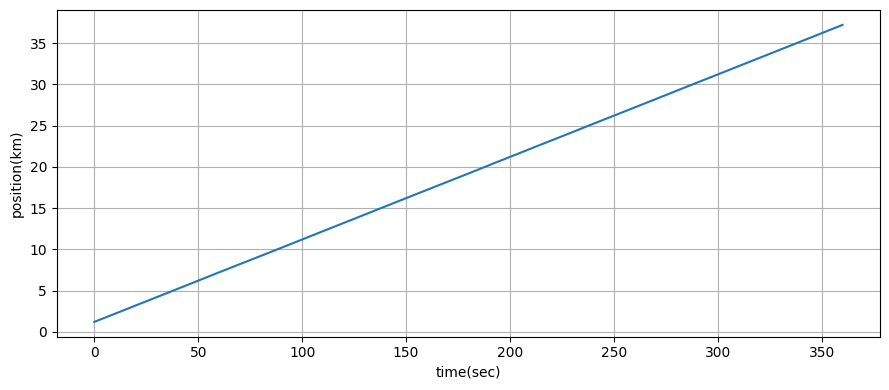

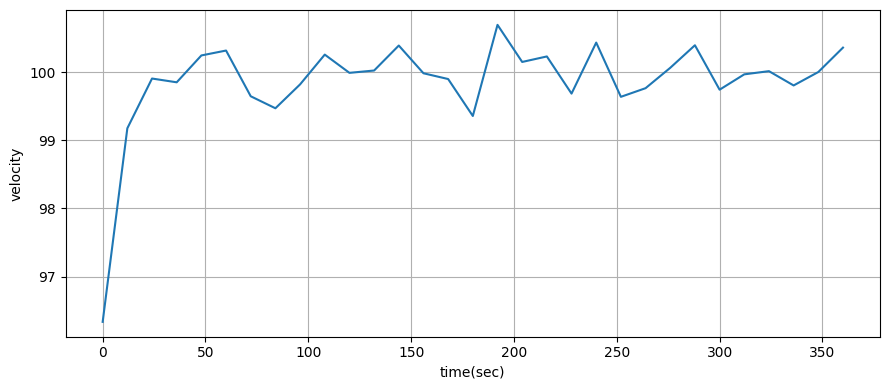

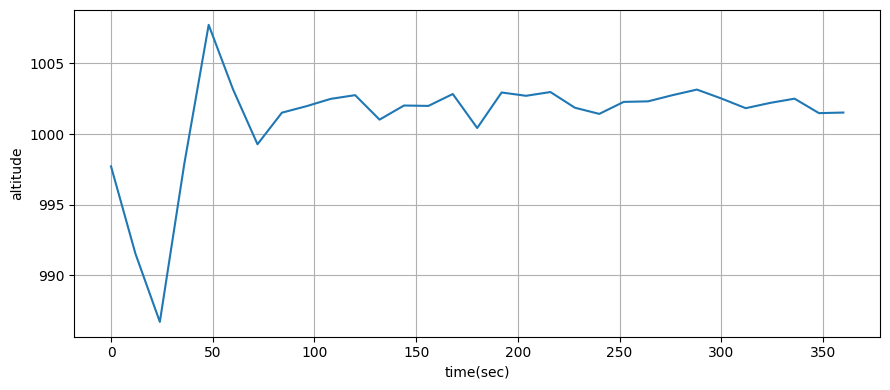

In [45]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2 ,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

radar = RadarStation((0, 0), range_std, bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

xs, covs = kf.batch_filter(zs)
ukf_internal.plot_radar(xs, t)

## Smoothing the Results

Assume that we are tracking a car. Suppose we get a noisy measurement that implies that the car is starting to turn to the left, but the state function has predicted that the car is moving straight. The Kalman filter has no choice but to move the state estimate somewhat towards the noisy measurement, as it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 

If we are collecting data and post-processing it we have measurements after the questionable one that informs us if a turn was made or not. Suppose the subsequent measurements all continue turning left. We can then be sure that the measurement was not very noisy, but instead a turn was initiated.

We will not develop the math or algorithm here, I will just show you how to call the algorithm in `FilterPy`. The algorithm that we have implemented is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel.

The routine is `UnscentedKalmanFilter.rts_smoother()`. Using it is trivial; we pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

Difference in position in meters:
	 [-1.4166 -0.2815  1.2679 -1.2405 -2.1863]


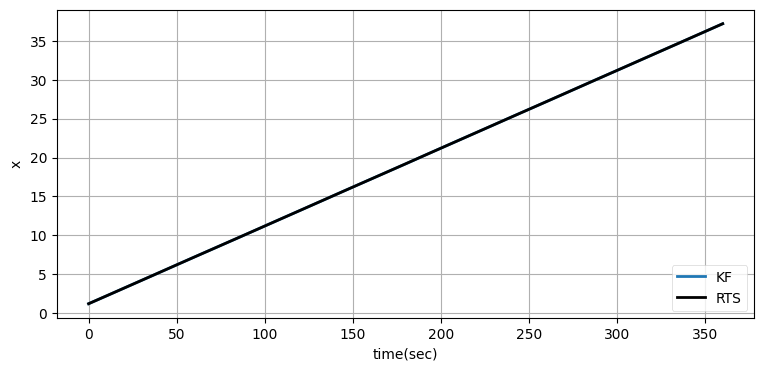

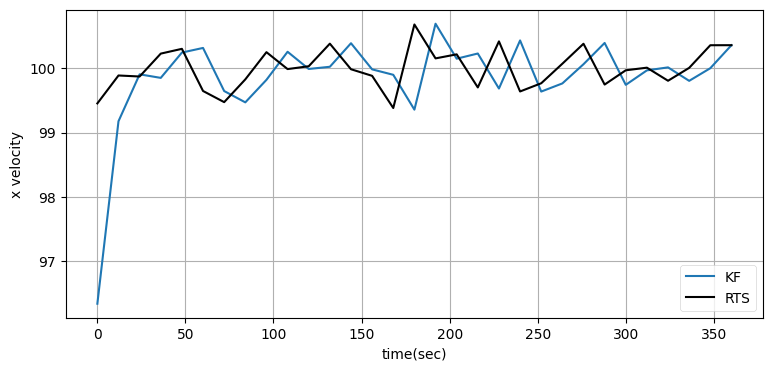

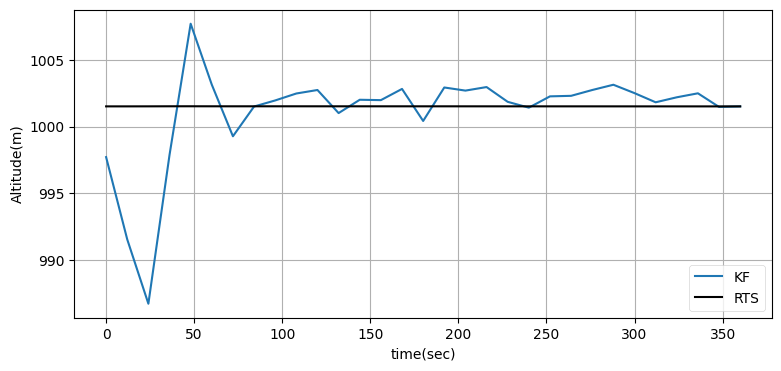

In [46]:
Ms, P, K = kf.rts_smoother(xs, covs)
ukf_internal.plot_rts_output(xs, Ms, t)

From these charts we can see that the improvement in the position is small, but the improvement in the velocity is good, and spectacular for the altitude. The difference in the position are very small, so I printed the difference between the UKF and the smoothed results for the last 5 points. I recommend always using the RTS smoother if you can post-process your data.

## Choosing the Sigma Parameters

I have found the literature on choosing values for $\alpha$, $\beta$, and $\kappa$ to be rather lacking. Van der Merwe's dissertation contains the most information, but it is not exhaustive. So let's explore what they do. 

Van der Merwe suggests using $\beta=2$ for Gaussian problems, and $\kappa=3-n$. So let's start there and vary $\alpha$. I will let $n=1$ to minimize the size of the arrays we need to look at and to avoid having to compute the square root of matrices.


## 选择Sigma参数

我发现关于选择$\alpha$、$\beta$和$\kappa$值的文献相当匮乏。范德梅尔韦的博士论文包含最多信息，但仍不全面。因此让我们探讨这些参数的作用。

范德梅尔建议高斯问题采用$\beta=2$，并设定$\kappa=3-n$。我们以此为起点，通过调整$\alpha$进行验证。为简化数组规模并避免矩阵开方运算，本文将$n=1$作为默认值。

In [47]:
from kf_book.ukf_internal import print_sigmas
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [0.6667 0.1667 0.1667]
cov weights: [2.6667 0.1667 0.1667]
lambda: 2
sum cov 2.9999999999999996


So what is going on here? We can see that for a mean of 0 the algorithm chooses sigma points of 0, 3, and -3, but why? Recall the equation for computing the sigma points:

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

My choice of $n=1$ reduces everything to scalars, allowing us to avoid computing the square root of matrices. So, for our values the equation is

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= \pm 3
\end{aligned}$$

So as $\alpha$ gets larger the sigma points get more spread out. Let's set it to an absurd value.


那么这里发生了什么？我们看到当均值为0时，算法选择了0、3和-3作为sigma点，但为什么？回顾计算sigma点的公式：

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

我选择$n=1$将所有变量简化为标量，从而避免计算矩阵的平方根。因此，对于我们的数值，方程变为：

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= \pm 3
\end{aligned}$$

可见当 $\alpha$ 增大时，sigma点分布会更分散。现在设一个极端值进行验证。

In [48]:
print_sigmas(mean=0, cov=3, alpha=200)

sigmas:  [   0.  600. -600.]
mean weights: [1. 0. 0.]
cov weights: [-39996.      0.      0.]
lambda: 119999
sum cov -39996.00000000001


We can see that the sigma points spread over 100 standard deviations. If our data was Gaussian we'd be incorporating data many standard deviations away from the mean; for nonlinear problems this is unlikely to produce good results. But suppose our distribution was not Gaussian, but instead had very fat tails? We might need to sample from those tails to get a good estimate, and hence it would make sense to make $\kappa$ larger (not 200, which was absurdly large to make the change in the sigma points stark). 

With a similar line of reasoning, suppose that our distribution has nearly no tails - the probability distribution looks more like an inverted parabola. In such a case we'd probably want to pull the sigma points in closer to the mean to avoid sampling in regions where there will never be real data.

Now let's look at the change in the weights. When we have $k+n=3$ the weights were 0.6667 for the mean, and 0.1667 for the two outlying sigma points. On the other hand, when $\alpha=200$ the mean weight shot up to 0.99999 and the outlier weights were set to 0.000004. Recall the equations for the weights:

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

We can see that as $\lambda$ gets larger the fraction for the weight of the mean ($\lambda/(n+\lambda)$) approaches 1, and the fraction for the weights of the rest of the sigma points approaches 0. This is invariant on the size of your covariance. So as we sample further and further away from the mean we end up giving less weight to those samples, and if we sampled very close to the mean we'd give very similar weights to all.

However, the advice that Van der Merwe gives is to constrain $\alpha$ in the range $0 \gt \alpha \ge 1$. He suggests $10^{-3}$ as a good value. Let's try that.


我们可以看到，这些 sigma 点分布在 100 个标准差范围内。如果我们的数据服从正态分布，那么这些数据点将远离均值多个标准差；对于非线性问题，这种情况不太可能产生良好结果。但假设我们的分布并非正态分布，而是具有极度肥厚的尾部呢？此时可能需要从尾部区域抽样才能获得可靠估计，因此增大$\kappa$参数（而非200——该值为突出σ点变化而设置的极端值）才合理。

同理推演：若分布几乎无尾部——概率分布更接近倒置抛物线形态。此时我们可能需要将σ点向均值靠拢，避免在永远不会出现真实数据的区域进行采样。

现在观察权重变化：当$k+n=3$时，均值权重为0.6667，两个外延σ点权重为0.1667。而当$\alpha=200$时，均值权重骤升至0.99999，离群点权重则降至0.000004。回顾权重计算公式：

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

可见当$\lambda$增大时，均值权重占比（$\lambda/(n+\lambda)$）趋近于1，其余标准差点权重占比趋近于0。此特性与协方差大小无关。因此当样本偏离均值越远时，其权重分配越小；若样本极接近均值，则所有样本权重将趋于相近。

然而范德梅尔韦建议将$\alpha$限制在$0 \gt \alpha \ge 1$区间内，并推荐取值$10^{-3}$。让我们尝试采用该参数。

In [49]:
print_sigmas(mean=0, cov=13, alpha=.001, kappa=0)

sigmas:  [ 0.      0.0036 -0.0036]
mean weights: [-999999.  500000.  500000.]
cov weights: [-999996.  500000.  500000.]
lambda: -0.999999
sum cov 3.9999989999923855


## Robot Localization - A Fully Worked Example

It is time to undertake a significant problem. Most books choose simple, textbook problems with simple answers, and you are left wondering how to implement a real world problem. This example will not teach you how to tackle any problem, but illustrates the type of things you will have to consider as you design and implement a filter. 

We will consider the problem of robot localization. In this scenario we have a robot that is moving through a landscape using a sensor to detect landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. It might be one of those small robots that vacuum your house, or a robot in a warehouse.

The robot has 4 wheels in the same configuration used by automobiles. It maneuvers by pivoting the front wheels. This causes the robot to pivot around the rear axle while moving forward. This is nonlinear behavior which we will have to model. 

The robot has a sensor that gives it approximate range and bearing to known targets in the landscape. This is nonlinear because computing a position from  a range and bearing requires square roots and trigonometry. 

Both the process model and measurement models are nonlinear. The UKF accommodates both, so we provisionally conclude that the UKF is a viable choice for this problem.

### Robot Motion Model

At a first approximation an automobile steers by pivoting the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modeling steering requires a complicated set of differential equations. 

For Kalman filtering, especially for lower speed robotic applications a simpler *bicycle model* has been found to perform well. This is a depiction of the model:

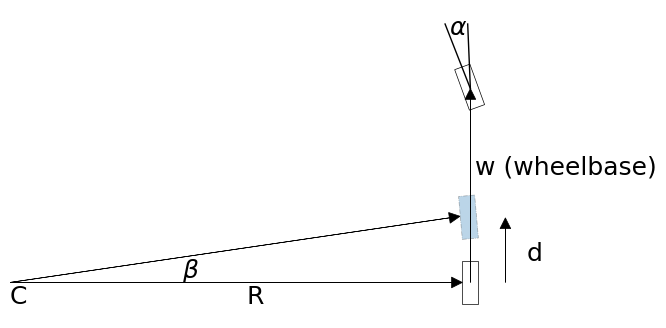

In [50]:
ekf_internal.plot_bicycle()

Here we see the front tire is pointing in direction $\alpha$ relative to the wheelbase. Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. Over such a short time frame we can approximate this as a turn around a radius $R$. We can compute the turn angle $\beta$ with

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

and the turning radius R is given by 

$$R = \frac{d}{\beta}$$

where the distance the rear wheel travels given a forward velocity $v$ is $d=v\Delta t$.

With $\theta$ being the robot's orientation we compute the position $C$ before the turn starts as

$$\begin{aligned}
C_x &= x - R\sin(\theta) \\
C_y &= y + R\cos(\theta)
\end{aligned}$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is

$$\begin{aligned} \bar x &= C_x + R\sin(\theta + \beta) \\
\bar y &= C_y - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

Once we substitute in for $C$ we get

$$\begin{aligned} \bar x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

You do not need to understand this math in detail if you are not interested in steering models. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.



在此我们看到前轮相对于轴距指向角度$\alpha$。在短时间内，车辆向前移动，后轮最终位置更靠前且略微向内转动，如蓝色阴影轮胎所示。在如此短的时间尺度下，可近似视为绕半径$R$的转弯。转弯角度$\beta$可通过下列公式计算：

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

转向半径$R$由下式给出：

$$R = \frac{d}{\beta}$$

其中后轮在前进速度$v$作用下移动的距离为$d=v\Delta t$。

设$\theta$为机器人的姿态角，则转向开始前的位置$C$计算为：

$$\begin{aligned}
C_x &= x - R\sin(\theta) \\
C_y &= y + R\cos(\theta)
\end{aligned}$$

前进时间 $\Delta t$ 后，机器人新位置与姿态为：

$$\begin{aligned} \bar x &= C_x + R\sin(\theta + \beta) \\
\bar y &= C_y - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

代入$C$后得到：

$$\begin{aligned} \bar x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

若您对转向模型不感兴趣，无需深入理解这些数学推导。关键在于认识到我们的运动模型具有非线性特征，这需要通过卡尔曼滤波器进行处理。

### Design the State Variables

For our robot we will maintain the position and orientation:

$$\mathbf x = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

I could include velocities into this model, but as you will see the math will already be quite challenging.

The control input $\mathbf{u}$ is the commanded velocity and steering angle

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$


### 设计状态变量

对于我们的机器人，我们将保持位置和姿态：

$$\mathbf x = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

我本可以将速度纳入此模型，但正如您将看到的，数学计算本身已相当具有挑战性。

控制输入 $\mathbf{u}$ 为指令速度与转向角：

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$

### Design the System Model

We model our system as a nonlinear motion model plus white noise.

$$\bar x = x + f(x, u) + \mathcal{N}(0, Q)$$

Using the motion model for a robot that we created above, we can write:

In [51]:
from math import tan, sin, cos, sqrt

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

We will use this function to implement the state transition function `f(x)`.

I will design the UKF so that $\Delta t$ is small. If the robot is moving slowly then this function should give a reasonably accurate prediction. If $\Delta t$ is large or your system's dynamics are very nonlinear this method will fail.  In those cases you will need to implement it using a more sophisticated numerical integration technique such as Runge Kutta. Numerical integration is covered briefly in the **Kalman Filter Math** chapter.


我将设计UKF使时间间隔$\Delta t$足够小。当机器人移动缓慢时，该函数应能提供相当精确的预测。若时间间隔过大或系统动力学具有强非线性特征，此方法将失效。在这些情况下，需采用更复杂的数值积分技术（如龙格-库塔法）进行实现。数值积分技术在**卡尔曼滤波数学原理**章节中有简要介绍。

### Design the Measurement Model

The sensor provides a noisy bearing and range to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ into a range and bearing to the landmark. If $p$ is the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

We assume that the sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$$

Thus our measurement function is

$$\begin{aligned}
\mathbf{z}& = h(\mathbf x, \mathbf P) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

I will not implement this yet as there is a difficulty that will be discussed in the *Implementation* section below.


### 设计测量模型

传感器为地形中多个已知位置提供带噪声的方位角和距离。测量模型需将状态向量 $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ 转换为地标的距离与方位角。若 $p$ 为地标位置，则距离 $r$ 计算式为：

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

假设传感器提供相对于机器人姿态的方位角，因此需从方位角中减去机器人姿态以获得传感器读数：

$$\phi = \tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$$

因此测量函数为：

$$\begin{aligned}
\mathbf{z}& = h(\mathbf x, \mathbf P) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

目前暂不实现该函数，因存在将在下文*实现*部分讨论的困难。

### Design Measurement Noise

It is reasonable to assume that the range and bearing measurement noise is independent, hence

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

Before we begin coding we have another issue to handle. The residual is $y = z - h(x)$. Suppose z has a bearing of $1^\circ$ and $h(x)$ is $359^\circ$. Subtracting them gives $-358^\circ$. This will throw off the computation of the Kalman gain because the correct angular difference is $2^\circ$. So we will have to write code to correctly compute the bearing residual.



在开始编码之前，我们还有另一个问题需要处理。残差为 $y = z - h(x)$。假设 z 的方位角为 $1^\circ$，而 $h(x)$ 为 $359^\circ$。相减后得到 $-358^\circ$。这将导致卡尔曼增益计算出现偏差，因为正确的角差应为 $2^\circ$。因此我们需要编写代码来正确计算方位残差。

In [52]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [53]:
print(np.degrees(normalize_angle(np.radians(1-359))))

1.9999999999999774


The state vector has the bearing at index 2, but the measurement vector has it at index 1, so we need to write functions to handle each. Another issue we face is that as the robot maneuvers different landmarks will be visible, so we need to handle a variable number of measurements. The function for the residual in the measurement will be passed an array of several measurements, one per landmark.

In [54]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

We can now implement the measurement model. The equation is
$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix}$$

The expression $\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$ can produce a result outside the range $[-\pi, \pi)$, so we should normalize the angle to that range.

The function will be passed an array of landmarks and needs to produce an array of measurements in the form `[dist_to_1, bearing_to_1, dist_to_2, bearing_to_2, ...]`.

In [55]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

Our difficulties are not over. The unscented transform computes the average of the state and measurement vectors, but each contains a bearing. There is no unique way to compute the average of a set of angles. For example, what is the average of 359$^\circ$ and 3$^\circ$? Intuition suggests the answer should be 1$^\circ$, but a naive $\frac{1}{n}\sum x$ approach yields 181$^\circ$.

One common approach is to take the arctan of the sum of the sins and cosines.

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

`UnscentedKalmanFilter.__init__()` has an argument `x_mean_fn` for a function which computes the mean of the state, and `z_mean_fn` for a function which computes the mean of the measurement. We will code these function as:


我们的困难尚未结束。无向量变换计算状态向量与测量向量的平均值，但每个向量都包含一个方位角。计算一组角度的平均值并无唯一方法。例如，359°与3°的平均值应为多少？直觉认为应为1°，但若采用简单的$\frac{1}{n}\sum x$方法，结果竟得出181°。

一种常用方法是计算正弦与余弦之和的反正切值：

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

`UnscentedKalmanFilter.__init__()` 包含参数 `x_mean_fn`（用于计算状态均值的函数）和 `z_mean_fn`（用于计算测量均值的函数）。我们将实现这些函数如下：

In [56]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

These functions take advantage of the fact that NumPy's trigometric functions operate on arrays, and `dot` performs element-wise multiplication. NumPy is implemented in C and Fortran, so `sum(dot(sin(x), w))` is much faster than writing the equivalent loop in Python.

With that done we are now ready to implement the UKF. I want to point out that when I designed this filter I did not just design all of functions above in one sitting, from scratch. I put together a basic UKF with predefined landmarks, verified it worked, then started filling in the pieces. "What if I see different landmarks?" That lead me to change the measurement function to accept an array of landmarks. "How do I deal with computing the residual of angles?" This led me to write the angle normalization code. "What is the *mean* of a set of angles?" I searched on the internet, found an article on Wikipedia, and implemented that algorithm. Do not be daunted. Design what you can, then ask questions and solve them, one by one.

You've seen the UKF implemention already, so I will not describe it in detail. There are two new things here. When we construct the sigma points and filter we have to provide it the functions that we have written to compute the residuals and means.

```python
points = SigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                     subtract=residual_x)

ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
         x_mean_fn=state_mean, z_mean_fn=z_mean,
         residual_x=residual_x, residual_z=residual_h)
```

Next, we need to pass extra data into our `f(x, dt)` and `h(x)` functions. We want to use `move(x, dt, u, wheelbase)` for `f(x, dt)`, and `Hx(x, landmarks)` for `h(x)`. We can do this, we just have to pass the extra parameters into `predict()` and `update()` as keyword arguments like so:

```python
            ukf.predict(u=u, wheelbase=wheelbase)        
            ukf.update(z, landmarks=landmarks)
```

The rest of the code runs the simulation and plots the results. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the UKF only once per second.  We are not using Runge Kutta to integrate the differential equations of motion, so a small time step makes the simulation more accurate.

In [65]:
from filterpy.stats import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

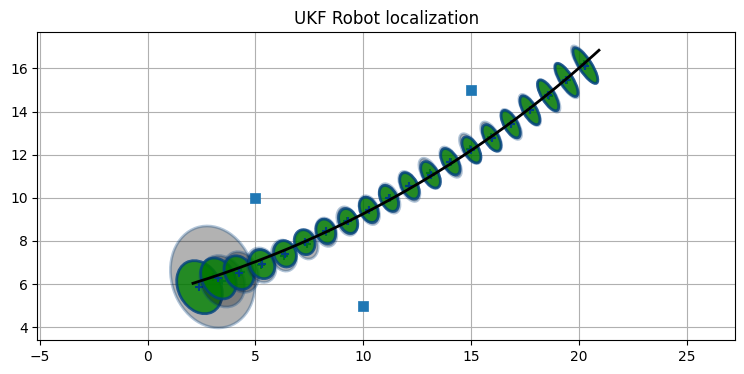

Final P: [0.0093 0.019  0.0007]


In [69]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

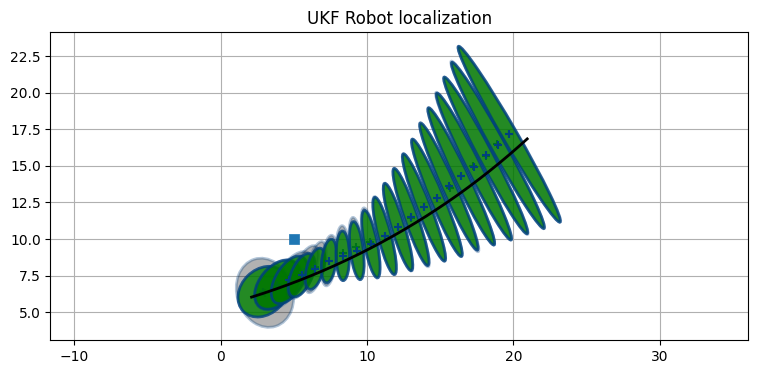

Final P: [0.3396 1.0018 0.0053]


In [70]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks[:1], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=1.4, sigma_bearing=0.05)
print('Final P:', ukf.P.diagonal())

The rest of the code runs the simulation and plots the results. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the UKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

### Steering the Robot

The steering simulation in the run above is not realistic. The velocity and steering angles never changed, which doesn't pose much of a problem for the Kalman filter. We could implement a complicated PID controlled robot simulation, but I will just generate varying steering commands using NumPy's `linspace` method. I'll also add more landmarks as the robot will be traveling much farther than in the first example.

In [59]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

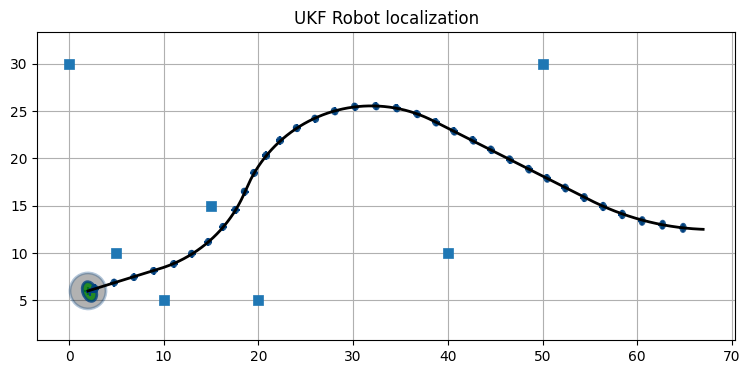

final covariance [0.0013 0.0043 0.0004]


In [60]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

The uncertainty becomes very small very quickly. The covariance ellipses are displaying the $6\sigma$ covariance, yet the ellipses are so small they are hard to see. We can incorporate more error into the answer by only supplying two landmarks near the start point. When we run this filter the errors increase as the robot gets further away from these landmarks.


不确定性会迅速变得非常小。协方差椭圆显示的是$6\sigma$协方差，然而这些椭圆如此微小以至于难以辨识。我们只需在起始点附近提供两个地标点，就能在结果中容纳更多误差。当运行此滤波器时，随着机器人远离这些地标点，误差会逐渐增大。

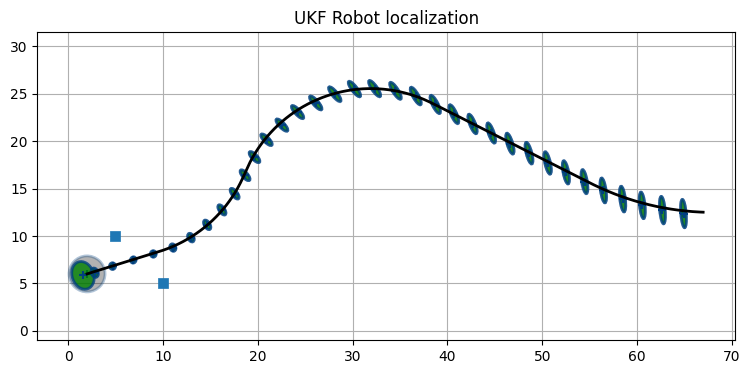

final covariance [0.0026 0.0657 0.0008]


In [61]:
ukf = run_localization(
    cmds, landmarks[0:2], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

## Discussion

Your impression of this chapter probably depends on how many nonlinear Kalman filters you have implemented in the past. If this is your first exposure perhaps the computation of $2n+1$ sigma points and the subsequent writing of the $f(x)$ and $h(x)$ function struck you as a bit finicky. Indeed, I spent more time than I'd care to admit getting everything working because of the need to handle the modular math of angles. On the other hand, if you have implemented an extended Kalman filter (EKF) perhaps you are bouncing gleefully in your seat. There is a small amount of tedium in writing the functions for the UKF, but the concepts are very basic. The EKF for the same problem requires some fairly difficult mathematics. For many problems we cannot find a closed form solution for the equations of the EKF, and we must retreat to some sort of iterated solution.

The advantage of the UKF over the EKF is not only the relative ease of implementation. It is somewhat premature to discuss this because you haven't learned the EKF yet, but the EKF linearizes the problem at one point and passes that point through a linear Kalman filter. In contrast, the UKF takes $2n+1$ samples. Therefore the UKF is often more accurate than the EKF, especially when the problem is highly nonlinear. While it is not true that the UKF is guaranteed to always outperform the EKF, in practice it has been shown to perform at least as well, and usually much better than the EKF. 

Hence my recommendation is to always start by implementing the UKF. If your filter has real world consequences if it diverges (people die, lots of money lost, power plant blows up) of course you will have to engage in sophisticated analysis and experimentation to choose the best filter. That is beyond the scope of this book, and you should be going to graduate school to learn this theory. 

Finally, I have spoken of the UKF as *the* way to perform sigma point filters. This is not true. The specific version I chose is Julier's scaled unscented filter as parameterized by Van der Merwe in his 2004 dissertation. If you search for Julier, Van der Merwe, Uhlmann, and Wan you will find a family of similar sigma point filters that they developed. Each technique uses a different way of choosing and weighting the sigma points. But the choices don't stop there. For example, the SVD Kalman filter uses singular value decomposition (SVD) to find the approximate mean and covariance of the probability distribution. Think of this chapter as an introduction to the sigma point filters, rather than a definitive treatment of how they work.



## 讨论

你对本章的印象可能取决于过去实现过多少个非线性卡尔曼滤波器。若这是你的初次接触，那么计算$2n+1$个西格玛点以及后续编写$f(x)$和$h(x)$函数的过程，或许让你觉得有些繁琐。诚然，由于需要处理角度的模数运算，我为此耗费的时间远超预期。但若你曾实现过扩展卡尔曼滤波器（EKF），此刻或许正欣喜若狂。虽然实现UKF函数时存在些许枯燥环节，但其核心概念极为基础——而处理相同问题的EKF则需要相当复杂的数学运算。对于许多问题，我们无法为EKF方程找到闭合形式解，只能退而求其次采用迭代求解法。

UKF相较EKF的优势不仅在于实现相对简单。虽然现在讨论还为时过早——毕竟你尚未学习EKF——但EKF会将问题线性化处理，再通过线性卡尔曼滤波器处理该点。相比之下，UKF需采集$2n+1$个样本。因此UKF通常比EKF更精确，尤其在高度非线性问题中。虽然不能断言UKF必然优于EKF，但实践证明其性能至少持平，通常远胜EKF。

故建议始终优先实现UKF。若滤波器发散会引现实后果（人员伤亡、巨额损失、电厂爆炸等），则需进行精密分析与实验以选择最佳滤波器。此类高阶理论超出本书范围，建议通过研究生课程深入学习。

最后需说明：我虽将UKF称为执行sigma点滤波的“唯一”方法，实则不然。我采用的是Julier提出的缩放无迹滤波器，其参数化方案源自Van der Merwe 2004年的博士论文。若检索Julier、Van der Merwe、Uhlmann和Wan等学者，可发现他们共同开发的同类sigma点滤波器家族。每种技术在选择和权重西格玛点时采用不同方法。但选择远不止于此。例如，奇异值分解卡尔曼滤波器（SVD Kalman filter）运用奇异值分解（SVD）来求解概率分布的近似均值与协方差。请将本章视为西格玛点滤波器的入门导引，而非其工作原理的权威论述。

## References

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [3] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [4] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [5] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition